In [19]:
!python -m spacy download pt_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 27.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# ===================================================================
# BRAZILIAN E-COMMERCE REVIEW CLASSIFICATION
# ===================================================================
# Dataset: Brazilian E-Commerce Public Dataset by Olist
# Challenge: Build a classification model for positive/negative reviews
# ===================================================================

import pandas as pd
import numpy as np
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Text processing
import re
import string
from collections import Counter

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)

# NLP libraries
try:
    import spacy
    nlp = spacy.load('pt_core_news_sm')
    SPACY_AVAILABLE = True
    print("SpaCy Portuguese model loaded successfully")
except:
    SPACY_AVAILABLE = False
    print("SpaCy Portuguese model not available")
    print("Install with: python -m spacy download pt_core_news_sm")

try:
    from textblob import TextBlob
    TEXTBLOB_AVAILABLE = True
    print("TextBlob available")
except:
    TEXTBLOB_AVAILABLE = False
    print("extBlob not available")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

print("Environment Setup Complete!")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Current working directory: {os.getcwd()}")

SpaCy Portuguese model loaded successfully
TextBlob available
Environment Setup Complete!
Pandas: 2.2.2
NumPy: 2.0.2
Current working directory: /content


In [ ]:
def load_olist_data_local(data_directory='data'):
    """
    Load all Olist dataset files from local directory

    Args:
        data_directory (str): Path to directory containing CSV files

    Returns:
        dict: Dictionary containing all datasets
    """

    # Convert to Path object
    data_path = Path('/content/drive/MyDrive/data')

    # List of all expected CSV files
    expected_files = [
        'olist_orders_dataset.csv',
        'olist_order_items_dataset.csv',
        'olist_order_reviews_dataset.csv',
        'olist_order_payments_dataset.csv',
        'olist_customers_dataset.csv',
        'olist_products_dataset.csv',
        'olist_sellers_dataset.csv',
        'olist_geolocation_dataset.csv',
        'product_category_name_translation.csv'
    ]

    datasets = {}
    loading_summary = []

    print("LOADING OLIST DATASET FROM LOCAL DIRECTORY")
    print("="*60)
    print(f"Data directory: {data_path.absolute()}")
    print(f"Looking for {len(expected_files)} CSV files...")
    print()

    # Check if directory exists
    if not data_path.exists():
        print(f"Directory not found: {data_path.absolute()}")
        print("1. Downloaded the Olist dataset from Kaggle")
        print("2. Extracted all CSV files to a 'data' folder")
        return None

    # Load each file
    for file in expected_files:
        file_path = data_path / file

        if file_path.exists():
            try:
                # Create clean table name
                table_name = file.replace('.csv', '').replace('olist_', '')

                # Load the dataset
                df = pd.read_csv(file_path)
                datasets[table_name] = df

                # Track loading info
                memory_mb = df.memory_usage(deep=True).sum() / 1024**2
                loading_summary.append({
                    'file': file,
                    'table_name': table_name,
                    'shape': df.shape,
                    'memory_mb': memory_mb,
                    'status': 'SUCCESS'
                })

                print(f"{table_name:25s} | Shape: {str(df.shape):15s} | Memory: {memory_mb:6.2f} MB")

            except Exception as e:
                loading_summary.append({
                    'file': file,
                    'table_name': 'ERROR',
                    'shape': (0, 0),
                    'memory_mb': 0,
                    'status': f'ERROR: {str(e)}'
                })
                print(f"{file:25s} | ERROR: {str(e)}")
        else:
            loading_summary.append({
                'file': file,
                'table_name': 'NOT_FOUND',
                'shape': (0, 0),
                'memory_mb': 0,
                'status': 'FILE_NOT_FOUND'
            })
            print(f"{file:25s} | FILE NOT FOUND")

    # Summary
    successful_loads = len([s for s in loading_summary if s['status'] == 'SUCCESS'])
    total_memory = sum([s['memory_mb'] for s in loading_summary if s['status'] == 'SUCCESS'])

    print()
    print("LOADING SUMMARY:")
    print(f"Successfully loaded: {successful_loads}/{len(expected_files)} files")
    print(f"Total memory usage: {total_memory:.2f} MB")

    if successful_loads == 0:
        print("\nNo files loaded successfully!")
        return None

    if successful_loads < len(expected_files):
        print(f"\n{len(expected_files) - successful_loads} files missing - analysis may be incomplete")

    return datasets

# Load the datasets
print("Starting data loading process...\n")
datasets = load_olist_data_local('data')  # Change 'data' to your actual folder path

# Verify loading success
if datasets is None:
    print("\nConfirm Data Availability:")
else:
    print(f"\nSUCCESS! Loaded {len(datasets)} datasets successfully!")

Starting data loading process...

LOADING OLIST DATASET FROM LOCAL DIRECTORY
Data directory: /content/drive/MyDrive/data
Looking for 9 CSV files...

orders_dataset            | Shape: (99441, 8)      | Memory:  52.94 MB
order_items_dataset       | Shape: (112650, 7)     | Memory:  35.99 MB
order_reviews_dataset     | Shape: (99224, 7)      | Memory:  39.12 MB
order_payments_dataset    | Shape: (103886, 5)     | Memory:  16.23 MB
customers_dataset         | Shape: (99441, 5)      | Memory:  26.59 MB
products_dataset          | Shape: (32951, 9)      | Memory:   6.30 MB
sellers_dataset           | Shape: (3095, 4)       | Memory:   0.59 MB
geolocation_dataset       | Shape: (1000163, 5)    | Memory: 129.38 MB
product_category_name_translation | Shape: (71, 2)         | Memory:   0.01 MB

LOADING SUMMARY:
Successfully loaded: 9/9 files
Total memory usage: 307.14 MB

SUCCESS! Loaded 9 datasets successfully!


In [40]:
"""
Dataset overview and initial inspection
"""
import pandas as pd

# Quick overview of loaded datasets
if datasets is not None:
    print("DATASET OVERVIEW")
    print("="*60)

    # Summary statistics
    total_datasets = len(datasets)
    total_records = sum(len(df) for df in datasets.values())
    total_memory = sum(df.memory_usage(deep=True).sum() for df in datasets.values()) / 1024**2

    print(f"Summary: {total_datasets} datasets, {total_records:,} total records, {total_memory:.1f} MB")

    # Individual dataset overview
    for i, (name, df) in enumerate(datasets.items(), 1):
        dataset_name = name.replace('_dataset', '').replace('_', ' ').title()
        print(f"\n{i}. {dataset_name}")
        print(f"   Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

        # Show key columns (first 5)
        key_columns = list(df.columns[:5])
        if len(df.columns) > 5:
            key_columns.append(f"... +{len(df.columns)-5} more")
        print(f"   Columns: {', '.join(key_columns)}")

        # Data types summary
        dtype_counts = df.dtypes.value_counts().to_dict()
        dtype_summary = ', '.join([f"{count} {dtype}" for dtype, count in dtype_counts.items()])
        print(f"   Types: {dtype_summary}")

    # Quick data sample from key dataset (orders or reviews)
    key_dataset = None
    if 'order_reviews_dataset' in datasets:
        key_dataset = datasets['order_reviews_dataset']
        dataset_type = "Reviews"
    elif 'orders_dataset' in datasets:
        key_dataset = datasets['orders_dataset']
        dataset_type = "Orders"

    if key_dataset is not None:
        print(f"\nSample from {dataset_type} Dataset:")
        display(key_dataset.head(3))

    print(f"\nDatasets loaded successfully! Ready for analysis.")

else:
    print("ERROR: No datasets loaded")
    print("Please check the data loading process before continuing")

DATASET OVERVIEW
Summary: 9 datasets, 1,550,922 total records, 307.1 MB

1. Orders
   Shape: 99,441 rows × 8 columns
   Columns: order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, ... +3 more
   Types: 8 object

2. Order Items
   Shape: 112,650 rows × 7 columns
   Columns: order_id, order_item_id, product_id, seller_id, shipping_limit_date, ... +2 more
   Types: 4 object, 2 float64, 1 int64

3. Order Reviews
   Shape: 99,224 rows × 7 columns
   Columns: review_id, order_id, review_score, review_comment_title, review_comment_message, ... +2 more
   Types: 6 object, 1 int64

4. Order Payments
   Shape: 103,886 rows × 5 columns
   Columns: order_id, payment_sequential, payment_type, payment_installments, payment_value
   Types: 2 object, 2 int64, 1 float64

5. Customers
   Shape: 99,441 rows × 5 columns
   Columns: customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state
   Types: 4 object, 1 int64

6. Products
   Shape: 32,95

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24



Datasets loaded successfully! Ready for analysis.


REVIEWS DATASET ANALYSIS
Dataset shape: (99224, 7)
Memory usage: 39.1 MB

Review Score Distribution:
Score 1: 11,424 (11.5%) █████
Score 2:  3,151 ( 3.2%) █
Score 3:  8,179 ( 8.2%) ████
Score 4: 19,142 (19.3%) █████████
Score 5: 57,328 (57.8%) ████████████████████████████

Text Availability:
• Reviews with title: 11,568 (11.7%)
• Reviews with message: 40,977 (41.3%)
• Reviews with any text: 42,706 (43.0%)

Text Length Statistics:
• Average message length: 28 characters
• Average title length: 1 characters
• Max message length: 208 characters


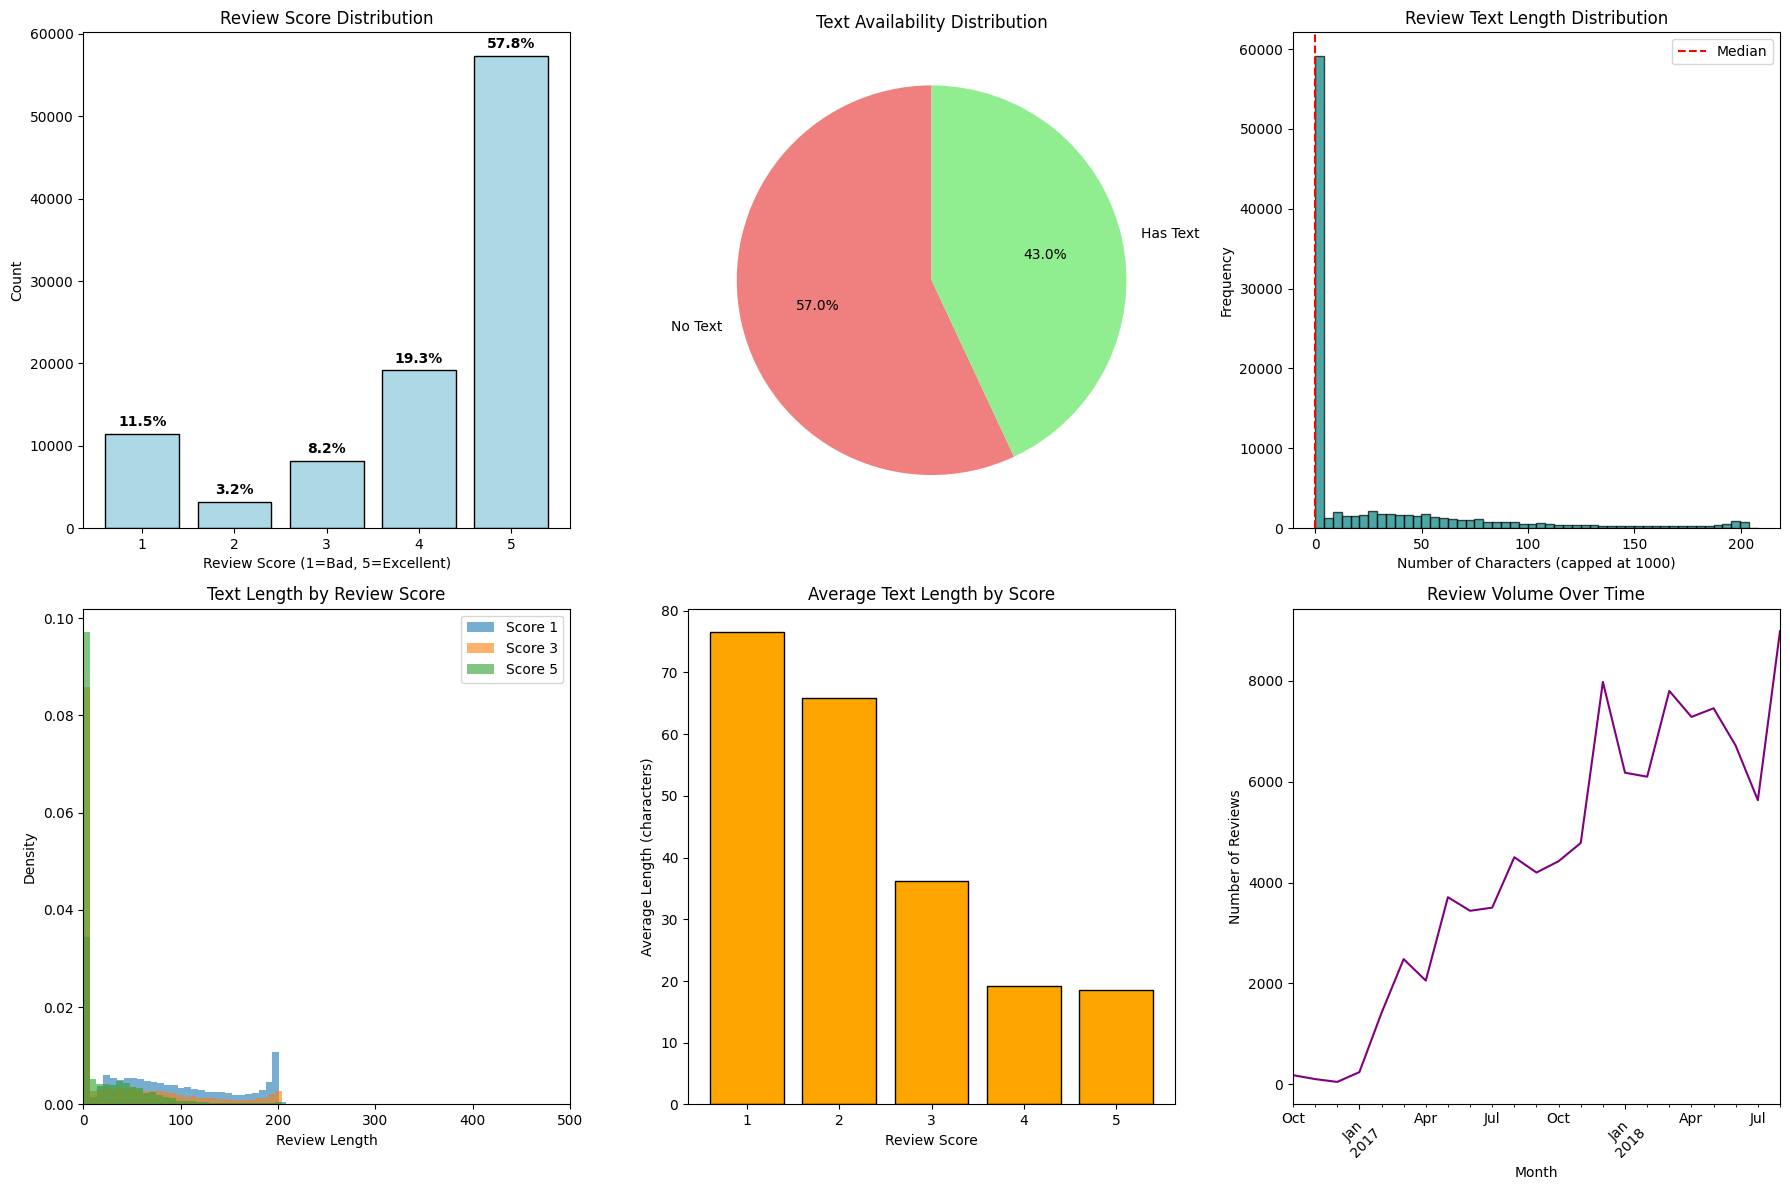


Sample Reviews by Score:

--- Score 1 Examples ---
1. Foi enviado produto Diferente daquele do anúncio. Solicitei devolver o produto e receber o valor pago, porém ainda não tive resposta. Espero resolver ...
2. Não comprem desta loja! Tentei fazer o cancelamento da compra por 5 vezes e só fui atende depois de ter recusado a entrega do Correio.

--- Score 3 Examples ---
1. Ainda não recebi então não posso avaliar 
2. Chegou bem fora do prazo. Mas, o site estava me informando do status do pedido. 

--- Score 5 Examples ---
1. O produto chegou muito rápido! Recomendo!
2. Apesar do produto ser de loja parceira a entrega foi rápida. E a boneca é linda: macia, gostosinha, muito legal!

Key Insights:
• Most reviews are positive (scores 4-5: 76,470 reviews)
• 43% of reviews have text content
• Average review length: 28 characters
• Dataset is heavily skewed toward positive reviews

Ready for text preprocessing and classification modeling!


In [41]:
"""
Exploratory Data Analysis on Reviews Dataset
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reviews Dataset Analysis
reviews = datasets.get("order_reviews_dataset")

print("REVIEWS DATASET ANALYSIS")
print("="*50)

# Basic dataset info
print(f"Dataset shape: {reviews.shape}")
print(f"Memory usage: {reviews.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Target distribution analysis
score_counts = reviews["review_score"].value_counts().sort_index()
score_percentages = (score_counts / len(reviews) * 100).round(1)

print(f"\nReview Score Distribution:")
for score, count in score_counts.items():
    pct = score_percentages[score]
    bar = "█" * int(pct / 2)
    print(f"Score {score}: {count:>6,} ({pct:>4.1f}%) {bar}")

# Text availability analysis
has_title = reviews["review_comment_title"].notna().sum()
has_message = reviews["review_comment_message"].notna().sum()
has_any_text = reviews[["review_comment_title", "review_comment_message"]].notna().any(axis=1).sum()

print(f"\nText Availability:")
print(f"• Reviews with title: {has_title:,} ({has_title/len(reviews)*100:.1f}%)")
print(f"• Reviews with message: {has_message:,} ({has_message/len(reviews)*100:.1f}%)")
print(f"• Reviews with any text: {has_any_text:,} ({has_any_text/len(reviews)*100:.1f}%)")

# Text length analysis
reviews["review_length"] = reviews["review_comment_message"].fillna("").apply(len)
reviews["title_length"] = reviews["review_comment_title"].fillna("").apply(len)

print(f"\nText Length Statistics:")
print(f"• Average message length: {reviews['review_length'].mean():.0f} characters")
print(f"• Average title length: {reviews['title_length'].mean():.0f} characters")
print(f"• Max message length: {reviews['review_length'].max():,} characters")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Review score distribution
axes[0,0].bar(score_counts.index, score_counts.values, color='lightblue', edgecolor='black')
axes[0,0].set_title('Review Score Distribution')
axes[0,0].set_xlabel('Review Score (1=Bad, 5=Excellent)')
axes[0,0].set_ylabel('Count')

for i, (score, count) in enumerate(score_counts.items()):
    pct = score_percentages[score]
    axes[0,0].text(score, count + max(score_counts.values)*0.01, f'{pct}%',
                  ha='center', va='bottom', fontweight='bold')

# 2. Text availability
text_data = [len(reviews) - has_any_text, has_any_text]
text_labels = ['No Text', 'Has Text']
colors = ['lightcoral', 'lightgreen']

axes[0,1].pie(text_data, labels=text_labels, autopct='%1.1f%%', colors=colors, startangle=90)
axes[0,1].set_title('Text Availability Distribution')

# 3. Review length distribution (capped for readability)
message_lengths = reviews['review_length'][reviews['review_length'] <= 1000]
axes[0,2].hist(message_lengths, bins=50, color='teal', alpha=0.7, edgecolor='black')
axes[0,2].set_title('Review Text Length Distribution')
axes[0,2].set_xlabel('Number of Characters (capped at 1000)')
axes[0,2].set_ylabel('Frequency')
axes[0,2].axvline(reviews['review_length'].median(), color='red', linestyle='--', label='Median')
axes[0,2].legend()

# 4. Text length by score
for score in [1, 3, 5]:
    score_lengths = reviews[reviews['review_score'] == score]['review_length']
    axes[1,0].hist(score_lengths, bins=30, alpha=0.6, label=f'Score {score}', density=True)

axes[1,0].set_title('Text Length by Review Score')
axes[1,0].set_xlabel('Review Length')
axes[1,0].set_ylabel('Density')
axes[1,0].legend()
axes[1,0].set_xlim(0, 500)

# 5. Average text length by score
avg_lengths = reviews.groupby('review_score')['review_length'].mean()
axes[1,1].bar(avg_lengths.index, avg_lengths.values, color='orange', edgecolor='black')
axes[1,1].set_title('Average Text Length by Score')
axes[1,1].set_xlabel('Review Score')
axes[1,1].set_ylabel('Average Length (characters)')

# 6. Review volume over time (if date available)
if 'review_creation_date' in reviews.columns:
    reviews['review_date'] = pd.to_datetime(reviews['review_creation_date'], errors='coerce')
    monthly_reviews = reviews.groupby(reviews['review_date'].dt.to_period('M')).size()

    if len(monthly_reviews) > 1:
        monthly_reviews.plot(ax=axes[1,2], color='purple')
        axes[1,2].set_title('Review Volume Over Time')
        axes[1,2].set_xlabel('Month')
        axes[1,2].set_ylabel('Number of Reviews')
        axes[1,2].tick_params(axis='x', rotation=45)
    else:
        axes[1,2].text(0.5, 0.5, 'Date data\nnot available', ha='center', va='center',
                      transform=axes[1,2].transAxes, fontsize=12)
        axes[1,2].set_title('Review Timeline')
else:
    axes[1,2].text(0.5, 0.5, 'Date data\nnot available', ha='center', va='center',
                  transform=axes[1,2].transAxes, fontsize=12)
    axes[1,2].set_title('Review Timeline')

plt.tight_layout()
plt.show()

# Sample reviews by score
print(f"\nSample Reviews by Score:")
for score in [1, 3, 5]:
    sample_reviews = reviews[
        (reviews["review_score"] == score) &
        (reviews["review_comment_message"].notna())
    ]["review_comment_message"].sample(min(2, len(reviews[reviews["review_score"] == score])),
                                       random_state=42)

    print(f"\n--- Score {score} Examples ---")
    for i, review in enumerate(sample_reviews, 1):
        preview = review[:150] + "..." if len(review) > 150 else review
        print(f"{i}. {preview}")

# Key insights summary
print(f"\nKey Insights:")
print(f"• Most reviews are positive (scores 4-5: {(score_counts[4] + score_counts[5]):,} reviews)")
print(f"• {has_any_text/len(reviews)*100:.0f}% of reviews have text content")
print(f"• Average review length: {reviews['review_length'].mean():.0f} characters")

if score_counts[5] > score_counts.sum() * 0.5:
    print(f"• Dataset is heavily skewed toward positive reviews")
else:
    print(f"• Dataset has reasonable score distribution for classification")

print(f"\nReady for text preprocessing and classification modeling!")

Starting data quality assessment...

DATA QUALITY ASSESSMENT

1/9: Orders Dataset
• Shape: 99,441 × 8 columns
• Memory: 52.9 MB
• Duplicates: 0
• Missing data: 3 columns

2/9: Order Items Dataset
• Shape: 112,650 × 7 columns
• Memory: 36.0 MB
• Duplicates: 0
• Missing data: 0 columns

3/9: Order Reviews Dataset
• Shape: 99,224 × 10 columns
• Memory: 41.4 MB
• Duplicates: 0
• Missing data: 2 columns
  High missing (>10%):
    - review_comment_title: 88%
    - review_comment_message: 59%

4/9: Order Payments Dataset
• Shape: 103,886 × 5 columns
• Memory: 16.2 MB
• Duplicates: 0
• Missing data: 0 columns

5/9: Customers Dataset
• Shape: 99,441 × 5 columns
• Memory: 26.6 MB
• Duplicates: 0
• Missing data: 0 columns

6/9: Products Dataset
• Shape: 32,951 × 9 columns
• Memory: 6.3 MB
• Duplicates: 0
• Missing data: 8 columns

7/9: Sellers Dataset
• Shape: 3,095 × 4 columns
• Memory: 0.6 MB
• Duplicates: 0
• Missing data: 0 columns

8/9: Geolocation Dataset
• Shape: 1,000,163 × 5 columns
• Me

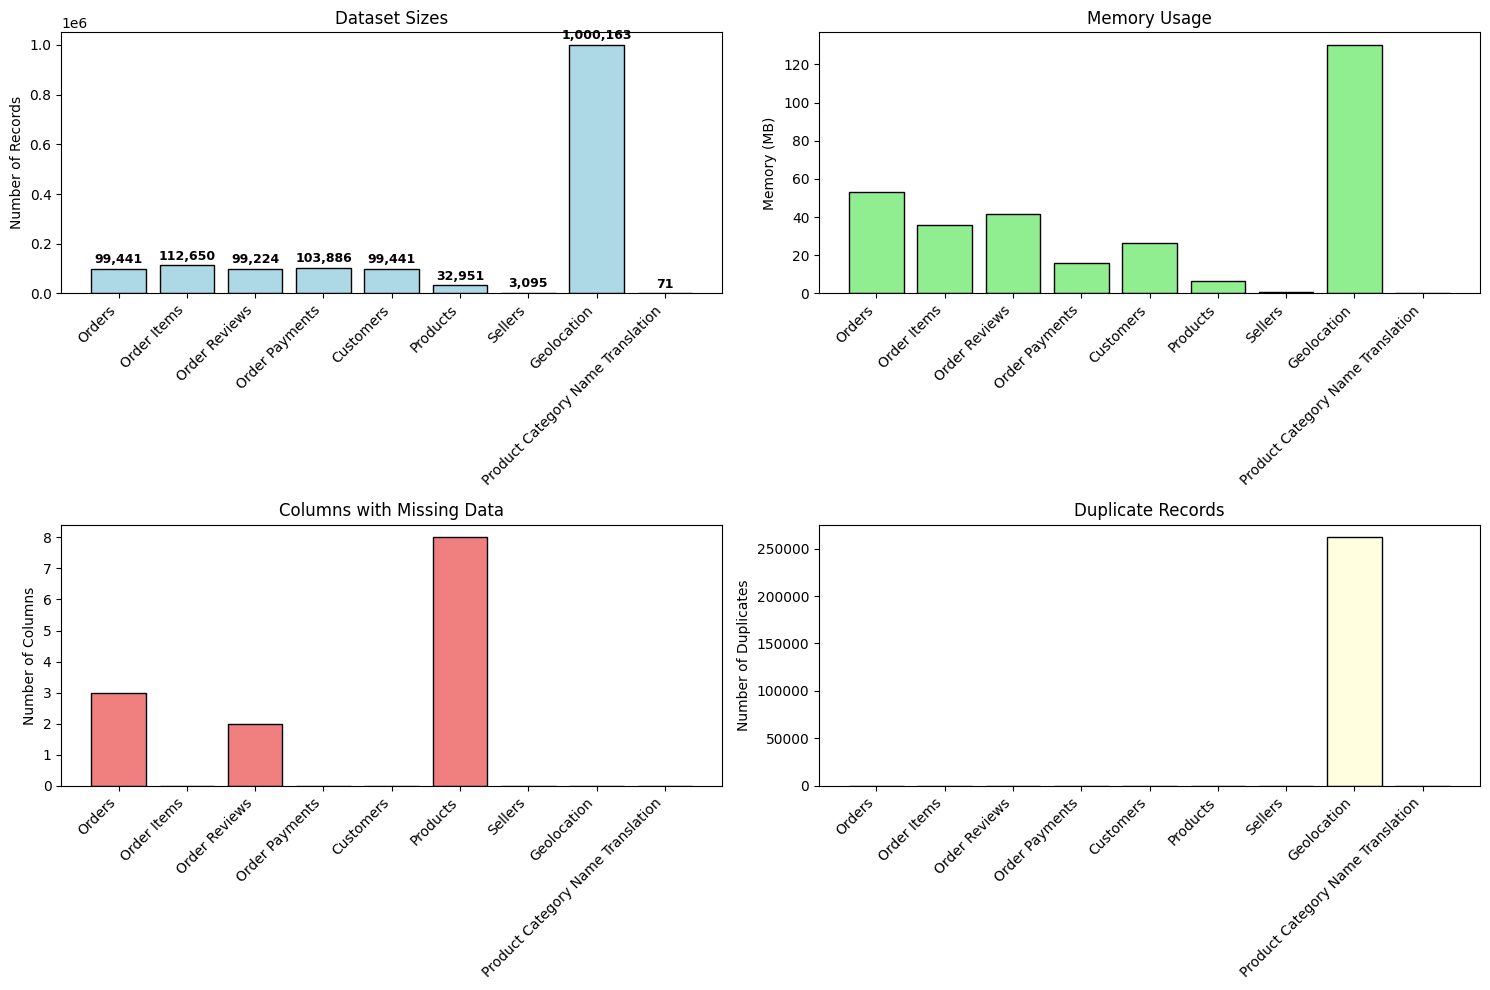


Overall Summary:
• Total datasets: 9
• Total records: 1,550,922
• Total memory: 310.3 MB
• Total duplicates: 261,831

Quality Flags:
orders_dataset: Many missing columns (3)
products_dataset: Many missing columns (8)
geolocation_dataset: High duplicates (261,831)

Data quality assessment complete!
Ready to proceed with data merging.


In [42]:
"""
Data quality assessment for all datasets
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def assess_data_quality_local(datasets):
    """
    Comprehensive data quality assessment for all datasets
    """

    if datasets is None:
        print("No datasets to assess")
        return None

    print("DATA QUALITY ASSESSMENT")
    print("="*60)

    quality_summary = {}
    total_datasets = len(datasets)

    for i, (name, df) in enumerate(datasets.items(), 1):
        print(f"\n{i}/{total_datasets}: {name.replace('_', ' ').title()}")

        # Basic metrics
        total_rows = len(df)
        total_cols = len(df.columns)
        missing_values = df.isnull().sum()
        duplicates = df.duplicated().sum()
        memory_mb = df.memory_usage(deep=True).sum() / 1024**2

        # Store summary
        quality_summary[name] = {
            'rows': total_rows,
            'columns': total_cols,
            'missing_columns': len(missing_values[missing_values > 0]),
            'duplicates': duplicates,
            'memory_mb': memory_mb,
            'missing_details': missing_values[missing_values > 0].to_dict()
        }

        print(f"• Shape: {total_rows:,} × {total_cols} columns")
        print(f"• Memory: {memory_mb:.1f} MB")
        print(f"• Duplicates: {duplicates:,}")
        print(f"• Missing data: {len(missing_values[missing_values > 0])} columns")

        # Show significant missing data
        high_missing = missing_values[missing_values > total_rows * 0.1]
        if len(high_missing) > 0:
            print(f"  High missing (>10%):")
            for col, count in high_missing.head(3).items():
                pct = count / total_rows * 100
                print(f"    - {col}: {pct:.0f}%")

    # Create summary visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Dataset sizes
    dataset_names = [name.replace('_dataset', '').replace('_', ' ').title() for name in quality_summary.keys()]
    dataset_sizes = [info['rows'] for info in quality_summary.values()]

    axes[0,0].bar(range(len(dataset_names)), dataset_sizes, color='lightblue', edgecolor='black')
    axes[0,0].set_title('Dataset Sizes')
    axes[0,0].set_ylabel('Number of Records')
    axes[0,0].set_xticks(range(len(dataset_names)))
    axes[0,0].set_xticklabels(dataset_names, rotation=45, ha='right')

    for i, size in enumerate(dataset_sizes):
        axes[0,0].text(i, size + max(dataset_sizes)*0.01, f'{size:,}',
                      ha='center', va='bottom', fontweight='bold', fontsize=9)

    # 2. Memory usage
    memory_usage = [info['memory_mb'] for info in quality_summary.values()]

    axes[0,1].bar(range(len(dataset_names)), memory_usage, color='lightgreen', edgecolor='black')
    axes[0,1].set_title('Memory Usage')
    axes[0,1].set_ylabel('Memory (MB)')
    axes[0,1].set_xticks(range(len(dataset_names)))
    axes[0,1].set_xticklabels(dataset_names, rotation=45, ha='right')

    # 3. Missing data prevalence
    missing_counts = [info['missing_columns'] for info in quality_summary.values()]

    axes[1,0].bar(range(len(dataset_names)), missing_counts, color='lightcoral', edgecolor='black')
    axes[1,0].set_title('Columns with Missing Data')
    axes[1,0].set_ylabel('Number of Columns')
    axes[1,0].set_xticks(range(len(dataset_names)))
    axes[1,0].set_xticklabels(dataset_names, rotation=45, ha='right')

    # 4. Duplicate records
    duplicate_counts = [info['duplicates'] for info in quality_summary.values()]

    axes[1,1].bar(range(len(dataset_names)), duplicate_counts, color='lightyellow', edgecolor='black')
    axes[1,1].set_title('Duplicate Records')
    axes[1,1].set_ylabel('Number of Duplicates')
    axes[1,1].set_xticks(range(len(dataset_names)))
    axes[1,1].set_xticklabels(dataset_names, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    # Overall summary
    total_records = sum(info['rows'] for info in quality_summary.values())
    total_memory = sum(info['memory_mb'] for info in quality_summary.values())
    total_duplicates = sum(info['duplicates'] for info in quality_summary.values())

    print(f"\nOverall Summary:")
    print(f"• Total datasets: {len(datasets)}")
    print(f"• Total records: {total_records:,}")
    print(f"• Total memory: {total_memory:.1f} MB")
    print(f"• Total duplicates: {total_duplicates:,}")

    # Data quality flags
    flags = []
    for name, info in quality_summary.items():
        if info['duplicates'] > info['rows'] * 0.05:
            flags.append(f"{name}: High duplicates ({info['duplicates']:,})")
        if info['missing_columns'] > info['columns'] * 0.3:
            flags.append(f"{name}: Many missing columns ({info['missing_columns']})")

    if flags:
        print(f"\nQuality Flags:")
        for flag in flags:
            print(f"{flag}")
    else:
        print(f"\n✓ No major quality issues detected")

    return quality_summary


# Run quality assessment
print("Starting data quality assessment...\n")
quality_report = assess_data_quality_local(datasets)

if quality_report:
    print(f"\nData quality assessment complete!")
    print(f"Ready to proceed with data merging.")
else:
    print("Quality assessment failed")

REVIEW DATA ANALYSIS - CLASSIFICATION TARGET
Total reviews: 99,224

REVIEW SCORE DISTRIBUTION:
         Score 1: 11,424 reviews ( 11.5%)
         Score 2:  3,151 reviews (  3.2%)
         Score 3:  8,179 reviews (  8.2%)
         Score 4: 19,142 reviews ( 19.3%)
         Score 5: 57,328 reviews ( 57.8%)

TEXT REVIEW ANALYSIS:
Reviews with title: 11,568 (11.7%)
Reviews with message: 40,977 (41.3%)
Reviews with any text: 42,706 (43.0%)

SAMPLE REVIEW TEXTS (Portuguese):
   Score 5: "Recebi bem antes do prazo estipulado."
   Score 5: "Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa"
   Score 4: "aparelho eficiente. no site a marca do aparelho esta impresso como 3desinfector e ao chegar esta com..."


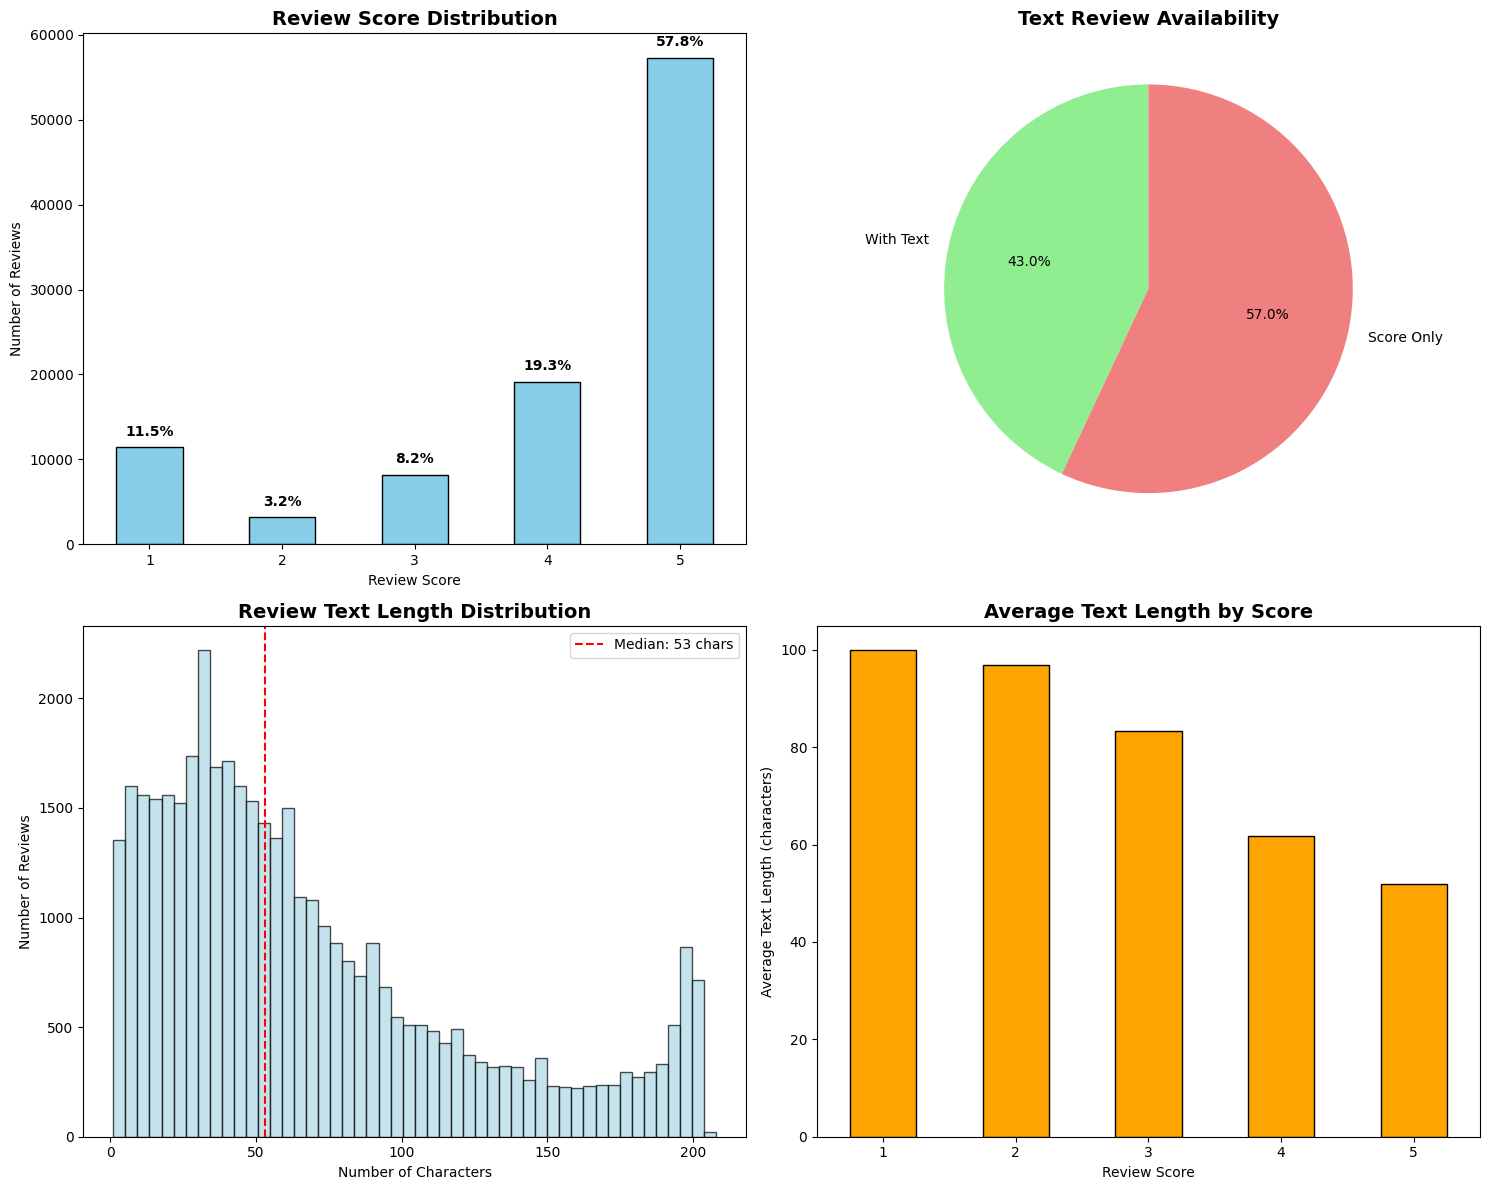

In [43]:
def analyze_review_data(datasets):
    """
    Deep dive into review data - the classification challenge
    """

    if 'order_reviews_dataset' not in datasets:
        print("Review dataset not found!")
        return None

    reviews_df = datasets['order_reviews_dataset']

    print("REVIEW DATA ANALYSIS - CLASSIFICATION TARGET")
    print("="*60)

    # Basic review statistics
    total_reviews = len(reviews_df)
    print(f"Total reviews: {total_reviews:,}")

    # Review score distribution
    print(f"\nREVIEW SCORE DISTRIBUTION:")
    score_dist = reviews_df['review_score'].value_counts().sort_index()
    score_percent = (score_dist / total_reviews * 100).round(2)

    for score in range(1, 6):
        count = score_dist.get(score, 0)
        percent = score_percent.get(score, 0)
        stars = "" * score
        print(f"   {stars:<5} Score {score}: {count:>6,} reviews ({percent:>5.1f}%)")

    # Text review availability
    print(f"\nTEXT REVIEW ANALYSIS:")
    has_title = reviews_df['review_comment_title'].notna().sum()
    has_message = reviews_df['review_comment_message'].notna().sum()
    has_any_text = reviews_df[['review_comment_title', 'review_comment_message']].notna().any(axis=1).sum()

    print(f"Reviews with title: {has_title:,} ({has_title/total_reviews*100:.1f}%)")
    print(f"Reviews with message: {has_message:,} ({has_message/total_reviews*100:.1f}%)")
    print(f"Reviews with any text: {has_any_text:,} ({has_any_text/total_reviews*100:.1f}%)")

    # Sample review texts (Portuguese)
    print(f"\nSAMPLE REVIEW TEXTS (Portuguese):")
    text_reviews = reviews_df[reviews_df['review_comment_message'].notna()]

    if len(text_reviews) > 0:
        for i, (_, row) in enumerate(text_reviews.head(3).iterrows()):
            score = row['review_score']
            text = row['review_comment_message'][:100] + "..." if len(str(row['review_comment_message'])) > 100 else row['review_comment_message']
            print(f"   Score {score}: \"{text}\"")

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Score distribution bar chart
    score_dist.plot(kind='bar', ax=axes[0,0], color='skyblue', edgecolor='black')
    axes[0,0].set_title('Review Score Distribution', fontweight='bold', fontsize=14)
    axes[0,0].set_xlabel('Review Score')
    axes[0,0].set_ylabel('Number of Reviews')
    axes[0,0].tick_params(rotation=0)

    # Add percentage labels on bars
    for i, v in enumerate(score_dist.values):
        axes[0,0].text(i, v + total_reviews*0.01, f'{score_percent.iloc[i]:.1f}%',
                      ha='center', va='bottom', fontweight='bold')

    # Text availability pie chart
    text_data = [has_any_text, total_reviews - has_any_text]
    labels = ['With Text', 'Score Only']
    colors = ['lightgreen', 'lightcoral']

    axes[0,1].pie(text_data, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    axes[0,1].set_title('Text Review Availability', fontweight='bold', fontsize=14)

    # Review length distribution (for reviews with text)
    if len(text_reviews) > 0:
        text_lengths = text_reviews['review_comment_message'].str.len()
        axes[1,0].hist(text_lengths, bins=50, color='lightblue', edgecolor='black', alpha=0.7)
        axes[1,0].set_title('Review Text Length Distribution', fontweight='bold', fontsize=14)
        axes[1,0].set_xlabel('Number of Characters')
        axes[1,0].set_ylabel('Number of Reviews')
        axes[1,0].axvline(text_lengths.median(), color='red', linestyle='--',
                         label=f'Median: {text_lengths.median():.0f} chars')
        axes[1,0].legend()

    # Score vs text length
    if len(text_reviews) > 0:
        text_reviews_sample = text_reviews.copy()
        text_reviews_sample['text_length'] = text_reviews_sample['review_comment_message'].str.len()

        score_length = text_reviews_sample.groupby('review_score')['text_length'].mean()
        score_length.plot(kind='bar', ax=axes[1,1], color='orange', edgecolor='black')
        axes[1,1].set_title('Average Text Length by Score', fontweight='bold', fontsize=14)
        axes[1,1].set_xlabel('Review Score')
        axes[1,1].set_ylabel('Average Text Length (characters)')
        axes[1,1].tick_params(rotation=0)

    plt.tight_layout()
    plt.show()

    return {
        'total_reviews': total_reviews,
        'score_distribution': score_dist.to_dict(),
        'score_percentages': score_percent.to_dict(),
        'text_availability': {
            'has_title': has_title,
            'has_message': has_message,
            'has_any_text': has_any_text
        }
    }

# Analyze review data
review_analysis = analyze_review_data(datasets)

Starting comprehensive data merging process...

CREATING COMPREHENSIVE MASTER DATASET
Starting with orders: 99,441 records
After order items: 99,441 records, 21 columns
After customers: 25 columns
After products: 33 columns
After sellers: 36 columns
After payments: 44 columns
After reviews: 53 columns
After categories: 54 columns

Dataset Summary:
• Final shape: (99992, 54)
• Memory usage: 188.9 MB
• Orders with reviews: 99,224
• Orders with text: 40,977


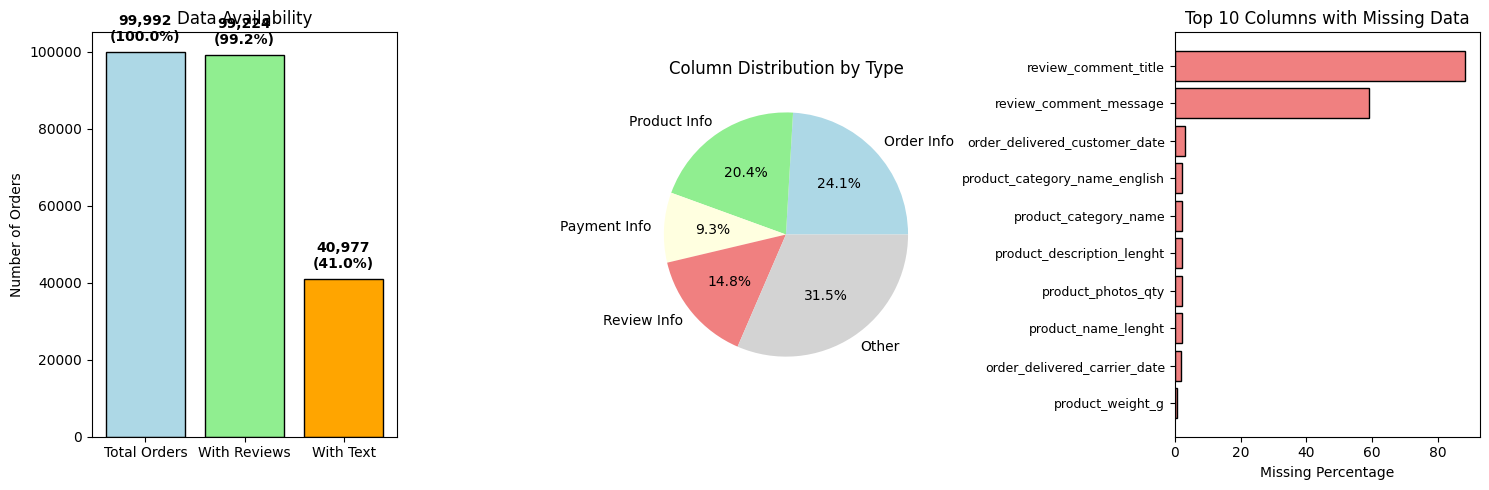


Master dataset creation complete!

Success! Master dataset created
Shape: (99992, 54)

Sample of key columns:


,order_id,total_items,total_price,review_score,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,1.0,29.99,4.0,SP
1,53cdb2fc8bc7dce0b6741e2150273451,1.0,118.70,4.0,BA
2,47770eb9100c2d0c44946d9cf07ec65d,1.0,159.90,5.0,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,1.0,45.00,5.0,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,1.0,19.90,5.0,SP



Ready for target variable creation!


In [44]:
"""
Comprehensive master dataset creation
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def create_comprehensive_master_dataset(datasets):
    """
    Create a comprehensive master dataset by joining all tables
    """

    if datasets is None:
        print("No datasets available for merging")
        return None

    print("CREATING COMPREHENSIVE MASTER DATASET")
    print("="*70)

    # Start with orders as the central hub
    if 'orders_dataset' not in datasets:
        print("Orders dataset not found! Cannot proceed.")
        return None

    master_df = datasets['orders_dataset'].copy()
    print(f"Starting with orders: {master_df.shape[0]:,} records")

    # Add order items with aggregation
    if 'order_items_dataset' in datasets:
        order_items = datasets['order_items_dataset'].copy()

        # Aggregate multiple items per order
        items_aggregated = order_items.groupby('order_id').agg({
            'order_item_id': 'count',
            'product_id': lambda x: '|'.join(x.astype(str)),
            'seller_id': lambda x: '|'.join(x.astype(str)),
            'price': ['sum', 'mean', 'std'],
            'freight_value': ['sum', 'mean']
        }).reset_index()

        # Flatten column names
        items_aggregated.columns = [
            'order_id', 'total_items', 'product_ids', 'seller_ids',
            'total_price', 'avg_item_price', 'price_std',
            'total_freight', 'avg_freight'
        ]

        # Add derived features
        items_aggregated['is_multi_item'] = (items_aggregated['total_items'] > 1).astype(int)
        items_aggregated['price_std'] = items_aggregated['price_std'].fillna(0)
        items_aggregated['total_order_value'] = items_aggregated['total_price'] + items_aggregated['total_freight']
        items_aggregated['freight_ratio'] = items_aggregated['total_freight'] / (items_aggregated['total_price'] + 0.01)
        items_aggregated['primary_product_id'] = items_aggregated['product_ids'].str.split('|').str[0]
        items_aggregated['primary_seller_id'] = items_aggregated['seller_ids'].str.split('|').str[0]

        master_df = master_df.merge(items_aggregated, on='order_id', how='left')
        print(f"After order items: {master_df.shape[0]:,} records, {master_df.shape[1]} columns")

    # Add customer information
    if 'customers_dataset' in datasets:
        customers = datasets['customers_dataset'].copy()
        master_df = master_df.merge(customers, on='customer_id', how='left')
        print(f"After customers: {master_df.shape[1]} columns")

    # Add product information
    if 'products_dataset' in datasets and 'primary_product_id' in master_df.columns:
        products = datasets['products_dataset'].copy()
        products_renamed = products.rename(columns={'product_id': 'primary_product_id'})
        master_df = master_df.merge(products_renamed, on='primary_product_id', how='left')
        print(f"After products: {master_df.shape[1]} columns")

    # Add seller information
    if 'sellers_dataset' in datasets and 'primary_seller_id' in master_df.columns:
        sellers = datasets['sellers_dataset'].copy()
        sellers_renamed = sellers.rename(columns={
            'seller_id': 'primary_seller_id',
            'seller_zip_code_prefix': 'seller_zip',
            'seller_city': 'seller_city',
            'seller_state': 'seller_state'
        })
        master_df = master_df.merge(sellers_renamed, on='primary_seller_id', how='left')
        print(f"After sellers: {master_df.shape[1]} columns")

    # Add payment information
    if 'order_payments_dataset' in datasets:
        payments = datasets['order_payments_dataset'].copy()

        # Aggregate payments per order
        payments_agg = payments.groupby('order_id').agg({
            'payment_sequential': 'count',
            'payment_type': lambda x: '|'.join(x),
            'payment_installments': ['sum', 'max'],
            'payment_value': 'sum'
        }).reset_index()

        payments_agg.columns = [
            'order_id', 'payment_methods_count', 'payment_types',
            'total_installments', 'max_installments', 'total_payment_value'
        ]

        payments_agg['uses_multiple_payments'] = (payments_agg['payment_methods_count'] > 1).astype(int)
        payments_agg['uses_installments'] = (payments_agg['max_installments'] > 1).astype(int)
        payments_agg['primary_payment_type'] = payments_agg['payment_types'].str.split('|').str[0]

        master_df = master_df.merge(payments_agg, on='order_id', how='left')
        print(f"After payments: {master_df.shape[1]} columns")

    # Add reviews (critical for classification)
    if 'order_reviews_dataset' in datasets:
        reviews = datasets['order_reviews_dataset'].copy()
        master_df = master_df.merge(reviews, on='order_id', how='left')
        print(f"After reviews: {master_df.shape[1]} columns")

    # Add English product categories
    if 'product_category_name_translation' in datasets:
        categories = datasets['product_category_name_translation'].copy()
        master_df = master_df.merge(categories, on='product_category_name', how='left')
        print(f"After categories: {master_df.shape[1]} columns")

    # Dataset summary
    reviews_available = master_df['review_score'].notna().sum()
    text_available = master_df['review_comment_message'].notna().sum()
    memory_mb = master_df.memory_usage(deep=True).sum() / 1024**2

    print(f"\nDataset Summary:")
    print(f"• Final shape: {master_df.shape}")
    print(f"• Memory usage: {memory_mb:.1f} MB")
    print(f"• Orders with reviews: {reviews_available:,}")
    print(f"• Orders with text: {text_available:,}")

    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 1. Data availability
    data_counts = [
        len(master_df),
        reviews_available,
        text_available
    ]
    data_labels = ['Total Orders', 'With Reviews', 'With Text']
    colors = ['lightblue', 'lightgreen', 'orange']

    axes[0].bar(data_labels, data_counts, color=colors, edgecolor='black')
    axes[0].set_title('Data Availability')
    axes[0].set_ylabel('Number of Orders')

    for i, v in enumerate(data_counts):
        pct = v / len(master_df) * 100
        axes[0].text(i, v + max(data_counts)*0.02, f'{v:,}\n({pct:.1f}%)',
                    ha='center', va='bottom', fontweight='bold')

    # 2. Missing data by column type
    column_types = {
        'Order Info': len([col for col in master_df.columns if any(word in col.lower() for word in ['order', 'customer'])]),
        'Product Info': len([col for col in master_df.columns if 'product' in col.lower()]),
        'Payment Info': len([col for col in master_df.columns if 'payment' in col.lower()]),
        'Review Info': len([col for col in master_df.columns if 'review' in col.lower()]),
        'Other': master_df.shape[1] - sum([len([col for col in master_df.columns if any(word in col.lower() for word in keywords)])
                                          for keywords in [['order', 'customer'], ['product'], ['payment'], ['review']]])
    }

    axes[1].pie(column_types.values(), labels=column_types.keys(), autopct='%1.1f%%',
               colors=['lightblue', 'lightgreen', 'lightyellow', 'lightcoral', 'lightgray'])
    axes[1].set_title('Column Distribution by Type')

    # 3. Top missing columns
    missing_data = master_df.isnull().sum().sort_values(ascending=False).head(10)
    missing_data = missing_data[missing_data > 0]

    if len(missing_data) > 0:
        missing_pct = (missing_data / len(master_df) * 100).round(1)
        axes[2].barh(range(len(missing_data)), missing_pct.values, color='lightcoral', edgecolor='black')
        axes[2].set_title('Top 10 Columns with Missing Data')
        axes[2].set_xlabel('Missing Percentage')
        axes[2].set_yticks(range(len(missing_data)))
        axes[2].set_yticklabels(missing_data.index, fontsize=9)
        axes[2].invert_yaxis()
    else:
        axes[2].text(0.5, 0.5, 'No Missing\nData Found', ha='center', va='center',
                    transform=axes[2].transAxes, fontsize=14)
        axes[2].set_title('Missing Data Status')

    plt.tight_layout()
    plt.show()

    print(f"\nMaster dataset creation complete!")

    return master_df


# Create the master dataset
print("Starting comprehensive data merging process...\n")
master_df = create_comprehensive_master_dataset(datasets)

if master_df is not None:
    print(f"\nSuccess! Master dataset created")
    print(f"Shape: {master_df.shape}")

    # Show key columns
    key_columns = ['order_id', 'total_items', 'total_price', 'review_score', 'customer_state']
    available_key_cols = [col for col in key_columns if col in master_df.columns]

    if available_key_cols:
        print(f"\nSample of key columns:")
        display(master_df[available_key_cols].head())

    print(f"\nReady for target variable creation!")
else:
    print("Failed to create master dataset")

Starting target variable creation...

CREATING CLASSIFICATION TARGET VARIABLE
Data Overview:
• Total orders: 99,992
• Orders with reviews: 99,224 (99.2%)

Review Score Distribution:
Score 1:   11,424 ( 11.5%) █████
Score 2:    3,151 (  3.2%) █
Score 3:    8,179 (  8.2%) ████
Score 4:   19,142 ( 19.3%) █████████
Score 5:   57,328 ( 57.8%) ████████████████████████████

Classification Strategy: 1-2 = Negative, 4-5 = Positive (Exclude 3)

Target Distribution:
• Negative (0): 14,575 (16.0%)
• Positive (1): 76,470 (84.0%)
• Excluded (3): 8,179 (8.2%)
• Final samples: 91,045

Class Balance:
• Positive:Negative ratio = 5.25:1
• Status: SEVERE IMBALANCE (68.0% difference)

Text Availability:
• Reviews with text: 39,062 (42.9%)


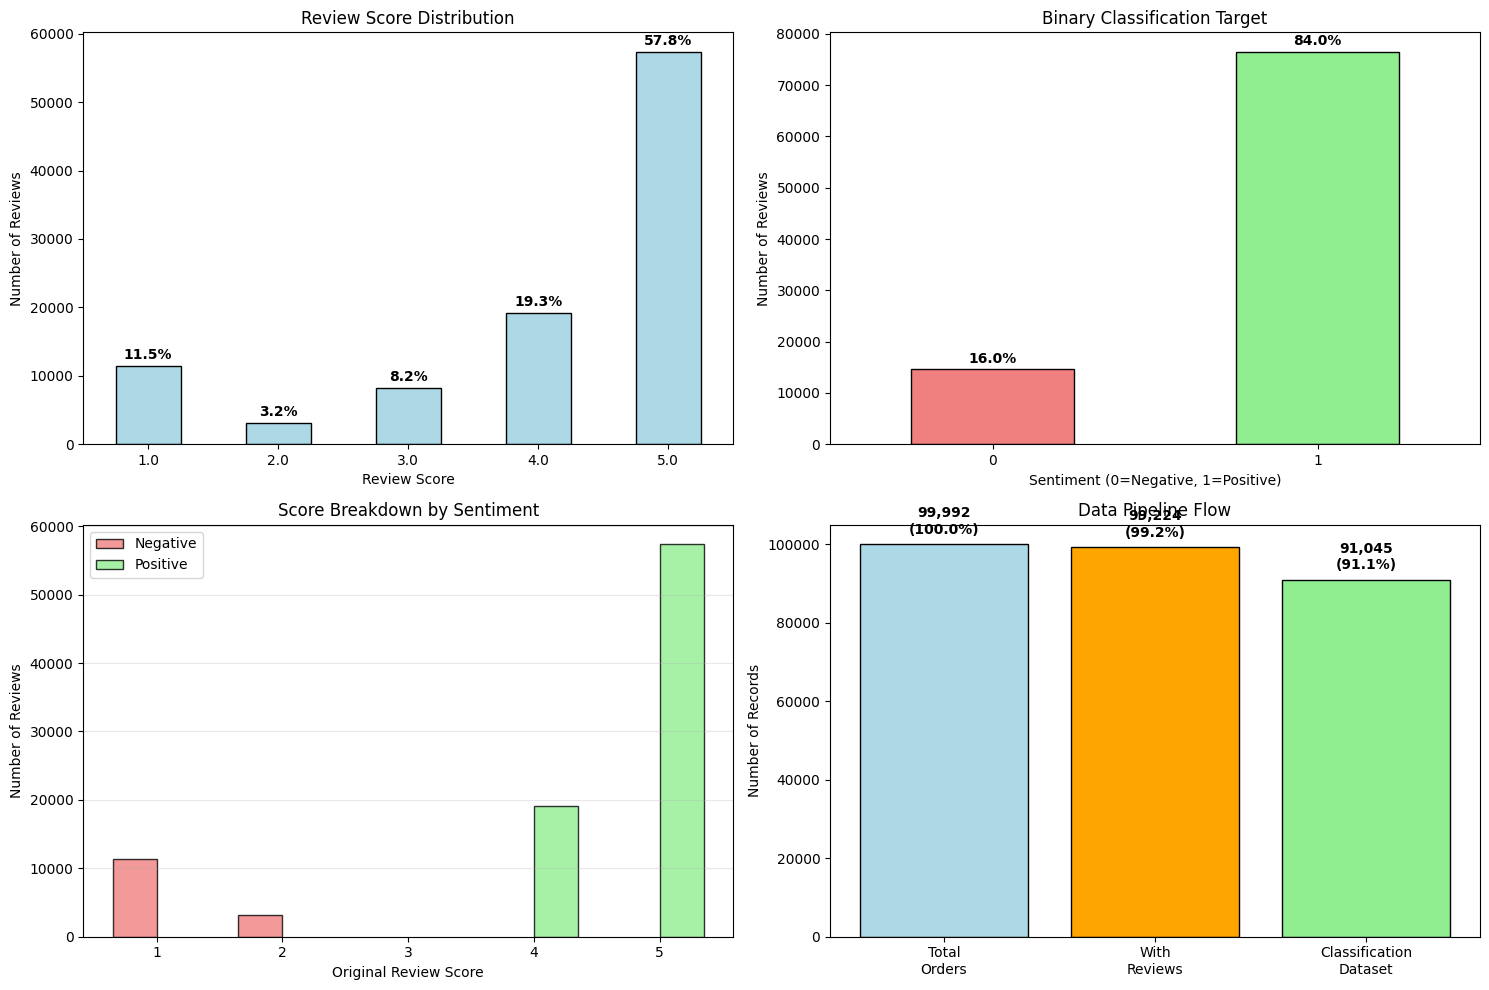


Target variable creation complete!
Classification dataset ready: 91,045 samples

Success! Classification dataset ready with 91,045 samples
Final target distribution:
• Negative: 14,575
• Positive: 76,470


In [45]:
"""
Target variable creation for classification
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def create_classification_target(df):
    """
    Create binary classification target from review scores
    """

    if df is None:
        print("No dataset provided")
        return None

    print("CREATING CLASSIFICATION TARGET VARIABLE")
    print("="*70)

    # Filter to orders with reviews only
    initial_orders = len(df)
    df_reviews = df[df['review_score'].notna()].copy()
    orders_with_reviews = len(df_reviews)

    print(f"Data Overview:")
    print(f"• Total orders: {initial_orders:,}")
    print(f"• Orders with reviews: {orders_with_reviews:,} ({orders_with_reviews/initial_orders*100:.1f}%)")

    if orders_with_reviews == 0:
        print("No orders with review scores found!")
        return None

    # Analyze review score distribution
    score_counts = df_reviews['review_score'].value_counts().sort_index()
    score_percentages = (score_counts / orders_with_reviews * 100).round(2)

    print(f"\nReview Score Distribution:")
    for score in range(1, 6):
        count = score_counts.get(score, 0)
        percentage = score_percentages.get(score, 0)
        bar = "█" * int(percentage / 2)
        print(f"Score {score}: {count:>8,} ({percentage:>5.1f}%) {bar}")

    # Create binary target (1-2 = Negative, 4-5 = Positive, 3 = Excluded)
    print(f"\nClassification Strategy: 1-2 = Negative, 4-5 = Positive (Exclude 3)")

    conditions = [
        df_reviews['review_score'].isin([1, 2]),  # Negative
        df_reviews['review_score'].isin([4, 5])   # Positive
    ]
    choices = [0, 1]  # 0=negative, 1=positive

    df_reviews['sentiment_binary'] = np.select(conditions, choices, default=np.nan)
    df_classification = df_reviews.dropna(subset=['sentiment_binary']).copy()
    df_classification['sentiment_binary'] = df_classification['sentiment_binary'].astype(int)

    # Analyze results
    final_samples = len(df_classification)
    target_dist = df_classification['sentiment_binary'].value_counts().sort_index()
    target_percentages = (target_dist / final_samples * 100).round(1)
    excluded_neutral = orders_with_reviews - final_samples

    print(f"\nTarget Distribution:")
    print(f"• Negative (0): {target_dist[0]:,} ({target_percentages[0]:.1f}%)")
    print(f"• Positive (1): {target_dist[1]:,} ({target_percentages[1]:.1f}%)")
    print(f"• Excluded (3): {excluded_neutral:,} ({excluded_neutral/orders_with_reviews*100:.1f}%)")
    print(f"• Final samples: {final_samples:,}")

    # Class balance analysis
    class_ratio = target_percentages[1] / target_percentages[0]
    imbalance = abs(target_percentages[0] - target_percentages[1])

    print(f"\nClass Balance:")
    print(f"• Positive:Negative ratio = {class_ratio:.2f}:1")
    if imbalance > 30:
        print(f"• Status: SEVERE IMBALANCE ({imbalance:.1f}% difference)")
    elif imbalance > 15:
        print(f"• Status: MODERATE IMBALANCE ({imbalance:.1f}% difference)")
    else:
        print(f"• Status: BALANCED CLASSES ({imbalance:.1f}% difference)")

    # Text availability
    has_any_text = df_classification[['review_comment_title', 'review_comment_message']].notna().any(axis=1).sum()
    text_coverage = has_any_text / final_samples * 100

    print(f"\nText Availability:")
    print(f"• Reviews with text: {has_any_text:,} ({text_coverage:.1f}%)")

    # Create alternative target strategies for comparison
    df_classification['sentiment_aggressive'] = np.where(
        df_classification['review_score'] <= 3, 0, 1
    )

    conditions_ultra = [
        df_classification['review_score'] == 1,
        df_classification['review_score'] == 5
    ]
    df_classification['sentiment_ultra'] = np.select(conditions_ultra, [0, 1], default=np.nan)

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Original score distribution
    score_counts.plot(kind='bar', ax=axes[0,0], color='lightblue', edgecolor='black')
    axes[0,0].set_title('Review Score Distribution')
    axes[0,0].set_xlabel('Review Score')
    axes[0,0].set_ylabel('Number of Reviews')
    axes[0,0].tick_params(rotation=0)

    for i, (score, count) in enumerate(score_counts.items()):
        pct = score_percentages[score]
        axes[0,0].text(i, count + max(score_counts.values)*0.01, f'{pct:.1f}%',
                      ha='center', va='bottom', fontweight='bold')

    # 2. Binary target distribution
    colors = ['lightcoral', 'lightgreen']
    target_dist.plot(kind='bar', ax=axes[0,1], color=colors, edgecolor='black')
    axes[0,1].set_title('Binary Classification Target')
    axes[0,1].set_xlabel('Sentiment (0=Negative, 1=Positive)')
    axes[0,1].set_ylabel('Number of Reviews')
    axes[0,1].tick_params(rotation=0)

    for i, (sentiment, count) in enumerate(target_dist.items()):
        pct = target_percentages[sentiment]
        axes[0,1].text(i, count + max(target_dist.values)*0.01, f'{pct:.1f}%',
                      ha='center', va='bottom', fontweight='bold')

    # 3. Score breakdown by sentiment
    for sentiment, color, label in [(0, 'lightcoral', 'Negative'), (1, 'lightgreen', 'Positive')]:
        subset = df_classification[df_classification['sentiment_binary'] == sentiment]
        score_breakdown = subset['review_score'].value_counts().sort_index()
        offset = (sentiment - 0.5) * 0.35
        axes[1,0].bar(score_breakdown.index + offset, score_breakdown.values,
                     width=0.35, label=label, color=color, edgecolor='black', alpha=0.8)

    axes[1,0].set_title('Score Breakdown by Sentiment')
    axes[1,0].set_xlabel('Original Review Score')
    axes[1,0].set_ylabel('Number of Reviews')
    axes[1,0].legend()
    axes[1,0].grid(axis='y', alpha=0.3)

    # 4. Data pipeline flow
    pipeline_data = [initial_orders, orders_with_reviews, final_samples]
    pipeline_labels = ['Total\nOrders', 'With\nReviews', 'Classification\nDataset']
    colors_pipeline = ['lightblue', 'orange', 'lightgreen']

    axes[1,1].bar(pipeline_labels, pipeline_data, color=colors_pipeline, edgecolor='black')
    axes[1,1].set_title('Data Pipeline Flow')
    axes[1,1].set_ylabel('Number of Records')

    for i, v in enumerate(pipeline_data):
        percentage = v / initial_orders * 100
        axes[1,1].text(i, v + max(pipeline_data)*0.02, f'{v:,}\n({percentage:.1f}%)',
                      ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    print(f"\nTarget variable creation complete!")
    print(f"Classification dataset ready: {final_samples:,} samples")

    return df_classification


# Create target variable
print("Starting target variable creation...\n")
df_with_target = create_classification_target(master_df)

if df_with_target is not None:
    print(f"\nSuccess! Classification dataset ready with {len(df_with_target):,} samples")

    # Show target distribution summary
    target_summary = df_with_target['sentiment_binary'].value_counts().sort_index()
    print(f"Final target distribution:")
    print(f"• Negative: {target_summary[0]:,}")
    print(f"• Positive: {target_summary[1]:,}")
else:
    print("Failed to create target variable")

Starting Portuguese text preprocessing...

PORTUGUESE TEXT PREPROCESSING PIPELINE
Text Analysis: 91,045 total samples
• Title: 10,744 (11.8%)
• Message: 37,420 (41.1%)
• Any text: 39,062 (42.9%)
Text retention: 39,062 samples (42.9%)
After cleaning: 38,875 samples retained
Text Statistics:
• Average length: 63 characters
• Average words: 10
• Text features created: 12


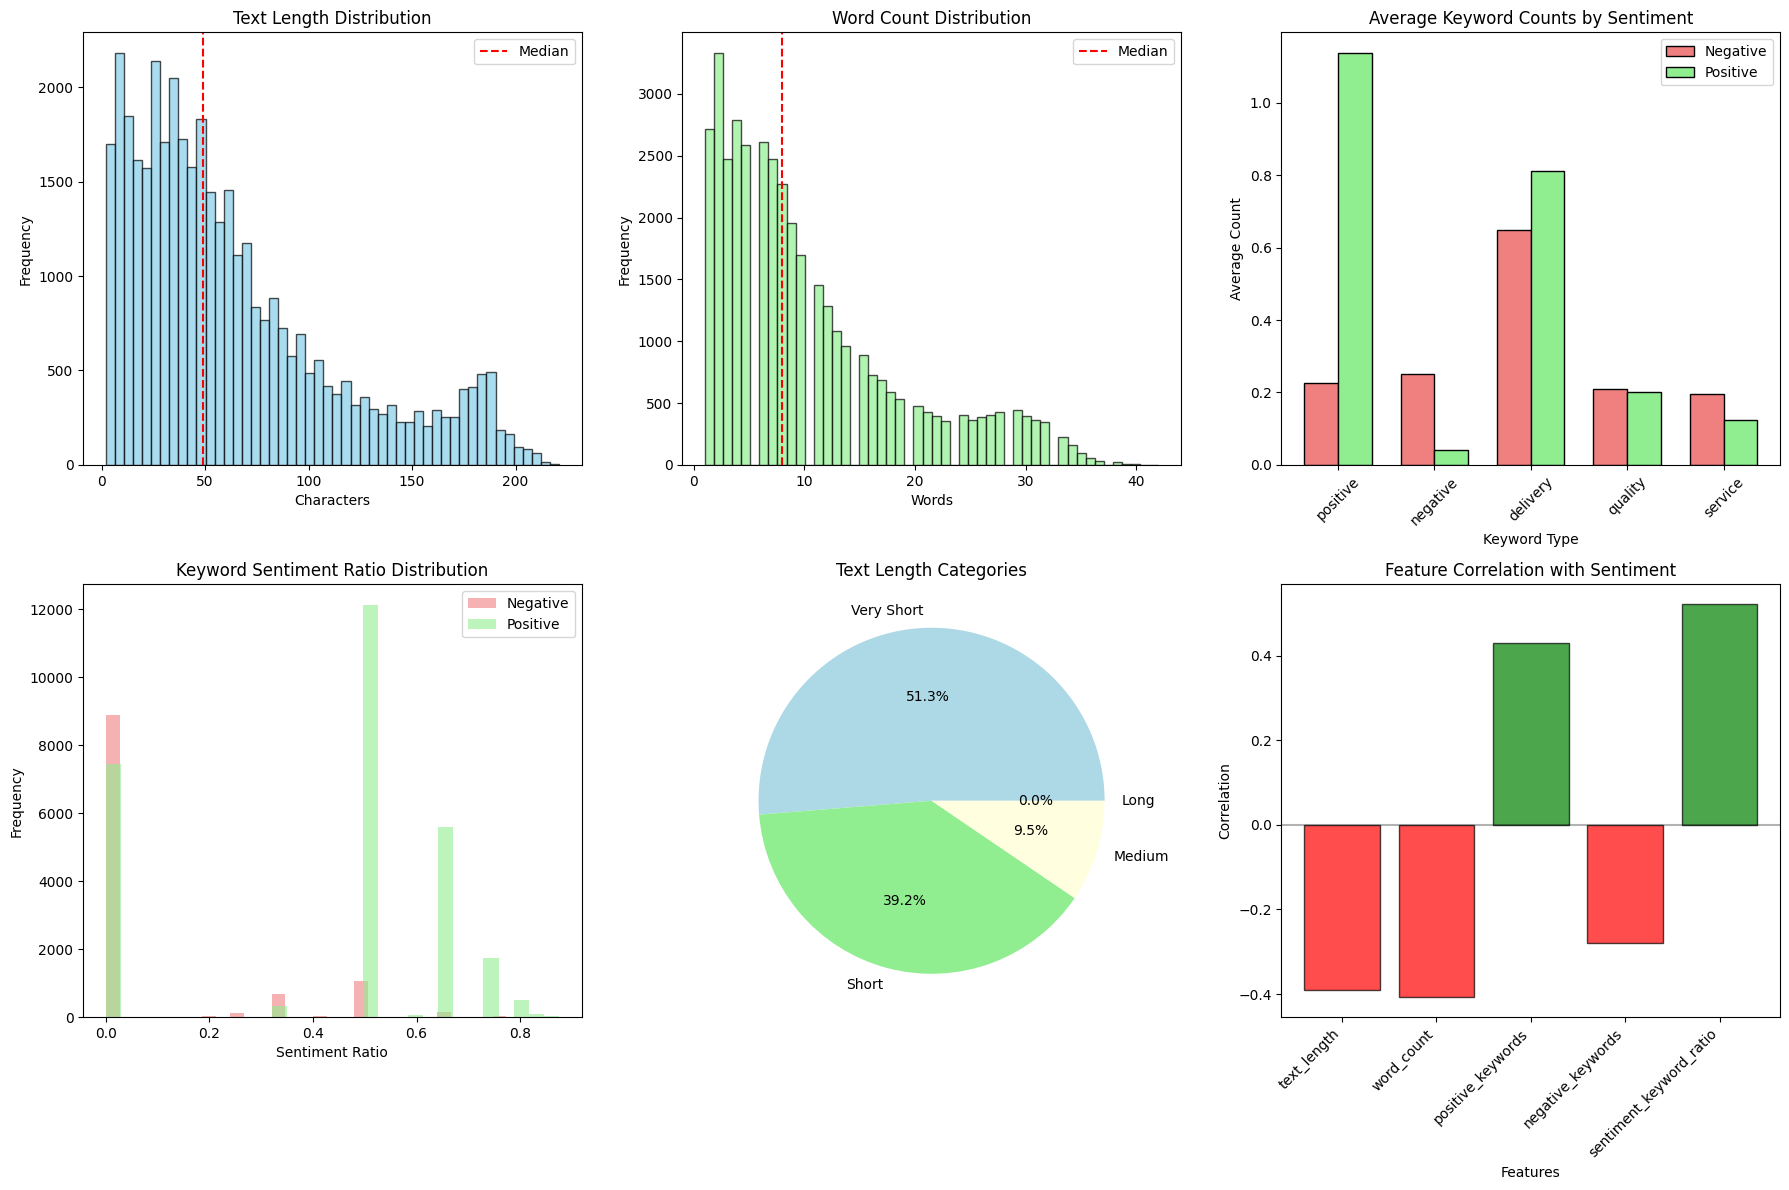


Text preprocessing complete!
Final dataset: 38,875 samples with text features

Success! Text preprocessing complete with 38,875 text samples
Text features created: 15
Sample text features:


,text_length,word_count,positive_keywords,negative_keywords,sentiment_keyword_ratio
0,155,27,2,1,0.500000
1,32,6,2,0,0.666667
3,96,16,1,0,0.500000
6,33,6,0,0,0.000000
10,26,4,0,0,0.000000


In [46]:
"""
Portuguese text preprocessing pipeline
"""
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

def preprocess_portuguese_text(df):
    """
    Comprehensive Portuguese text preprocessing pipeline
    """

    if df is None:
        print("No dataset provided")
        return None

    print("PORTUGUESE TEXT PREPROCESSING PIPELINE")
    print("="*70)

    df_text = df.copy()

    # Text availability analysis
    total_samples = len(df_text)
    has_title = df_text['review_comment_title'].notna().sum()
    has_message = df_text['review_comment_message'].notna().sum()
    has_any_text = df_text[['review_comment_title', 'review_comment_message']].notna().any(axis=1).sum()

    print(f"Text Analysis: {total_samples:,} total samples")
    print(f"• Title: {has_title:,} ({has_title/total_samples*100:.1f}%)")
    print(f"• Message: {has_message:,} ({has_message/total_samples*100:.1f}%)")
    print(f"• Any text: {has_any_text:,} ({has_any_text/total_samples*100:.1f}%)")

    # Combine title and message
    def combine_review_text(row):
        title = str(row['review_comment_title']) if pd.notna(row['review_comment_title']) else ""
        message = str(row['review_comment_message']) if pd.notna(row['review_comment_message']) else ""

        combined = ""
        if title and title != "nan":
            combined += title
        if message and message != "nan":
            if combined:
                combined += " " + message
            else:
                combined = message

        return combined if combined else None

    df_text['review_text_combined'] = df_text.apply(combine_review_text, axis=1)

    # Filter to samples with text
    text_samples_before = len(df_text)
    df_text = df_text[df_text['review_text_combined'].notna()].copy()
    text_samples_after = len(df_text)

    print(f"Text retention: {text_samples_after:,} samples ({text_samples_after/text_samples_before*100:.1f}%)")

    if text_samples_after == 0:
        print("No samples with text found!")
        return df

    # Portuguese text cleaning
    def clean_portuguese_text(text):
        if pd.isna(text) or text == "":
            return ""

        text = str(text).lower()

        # Remove URLs and emails
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'\S+@\S+', '', text)

        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)

        # Handle Portuguese specific characters
        text = re.sub(r'[^\w\s\-àáâãäèéêëìíîïòóôõöùúûüç]', ' ', text)

        # Remove extra whitespace and short words
        text = re.sub(r'\s+', ' ', text).strip()
        text = ' '.join([word for word in text.split() if len(word) >= 2])

        return text

    # Apply cleaning
    df_text['review_text_cleaned'] = df_text['review_text_combined'].apply(clean_portuguese_text)

    # Remove empty cleaned texts
    non_empty_before = len(df_text)
    df_text = df_text[df_text['review_text_cleaned'].str.len() > 0].copy()
    non_empty_after = len(df_text)

    print(f"After cleaning: {non_empty_after:,} samples retained")

    # Basic text features
    text_lengths = df_text['review_text_cleaned'].str.len()
    word_counts = df_text['review_text_cleaned'].str.split().str.len()

    df_text['text_length'] = text_lengths
    df_text['word_count'] = word_counts
    df_text['avg_word_length'] = df_text['review_text_cleaned'].apply(
        lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0
    )
    df_text['exclamation_count'] = df_text['review_text_combined'].str.count('!')
    df_text['question_count'] = df_text['review_text_combined'].str.count('\?')
    df_text['uppercase_ratio'] = df_text['review_text_combined'].apply(
        lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if len(str(x)) > 0 else 0
    )

    # Portuguese sentiment keywords
    positive_keywords = [
        'bom', 'boa', 'ótimo', 'ótima', 'excelente', 'perfeito', 'perfeita',
        'maravilhoso', 'maravilhosa', 'adorei', 'amei', 'recomendo',
        'rápido', 'rápida', 'qualidade', 'barato', 'barata', 'eficiente', 'pontual',
        'bem', 'gostei', 'feliz', 'satisfeito', 'satisfeita', 'top', 'show', 'legal'
    ]

    negative_keywords = [
        'ruim', 'péssimo', 'péssima', 'horrível', 'terrível', 'odeio', 'odiei',
        'não recomendo', 'demorou', 'atrasado', 'atrasada', 'defeito', 'quebrado',
        'quebrada', 'caro', 'cara', 'lento', 'lenta', 'problema',
        'decepcionado', 'decepcionante', 'insatisfeito', 'insatisfeita', 'mal',
        'danificado', 'danificada', 'mentira', 'enganoso'
    ]

    delivery_keywords = [
        'entrega', 'entregar', 'entregue', 'prazo', 'atraso', 'atrasou',
        'correios', 'transportadora', 'frete', 'envio', 'chegou', 'recebido',
        'tempo', 'demorou', 'rapidez', 'rápido', 'rápida'
    ]

    quality_keywords = [
        'qualidade', 'material', 'acabamento', 'durabilidade', 'resistente',
        'frágil', 'barato', 'caro', 'valor', 'preço', 'custo', 'benefício',
        'descrito', 'descrição', 'diferente', 'igual', 'como', 'esperava'
    ]

    service_keywords = [
        'atendimento', 'vendedor', 'loja', 'comunicação', 'resposta',
        'solução', 'problema', 'ajuda', 'suporte', 'cortês', 'educado',
        'rude', 'ignorou', 'atenção', 'cuidado'
    ]

    # Extract keyword features
    def count_keywords(text, keyword_list):
        if pd.isna(text) or text == "":
            return 0
        text_lower = str(text).lower()
        return sum(keyword in text_lower for keyword in keyword_list)

    df_text['positive_keywords'] = df_text['review_text_cleaned'].apply(
        lambda x: count_keywords(x, positive_keywords)
    )
    df_text['negative_keywords'] = df_text['review_text_cleaned'].apply(
        lambda x: count_keywords(x, negative_keywords)
    )
    df_text['delivery_keywords'] = df_text['review_text_cleaned'].apply(
        lambda x: count_keywords(x, delivery_keywords)
    )
    df_text['quality_keywords'] = df_text['review_text_cleaned'].apply(
        lambda x: count_keywords(x, quality_keywords)
    )
    df_text['service_keywords'] = df_text['review_text_cleaned'].apply(
        lambda x: count_keywords(x, service_keywords)
    )

    # Sentiment ratio
    df_text['sentiment_keyword_ratio'] = (
        df_text['positive_keywords'] / (df_text['positive_keywords'] + df_text['negative_keywords'] + 1)
    )

    # Text length categories
    df_text['length_category'] = pd.cut(df_text['text_length'],
                                      bins=[0, 50, 150, 500, float('inf')],
                                      labels=['Very Short', 'Short', 'Medium', 'Long'])

    print(f"Text Statistics:")
    print(f"• Average length: {text_lengths.mean():.0f} characters")
    print(f"• Average words: {word_counts.mean():.0f}")
    print(f"• Text features created: 12")

    # Create visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Text length distribution
    axes[0,0].hist(df_text['text_length'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Text Length Distribution')
    axes[0,0].set_xlabel('Characters')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].axvline(df_text['text_length'].median(), color='red', linestyle='--', label='Median')
    axes[0,0].legend()

    # 2. Word count distribution
    axes[0,1].hist(df_text['word_count'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0,1].set_title('Word Count Distribution')
    axes[0,1].set_xlabel('Words')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].axvline(df_text['word_count'].median(), color='red', linestyle='--', label='Median')
    axes[0,1].legend()

    # 3. Keyword counts by sentiment
    if 'sentiment_binary' in df_text.columns:
        keyword_features = ['positive_keywords', 'negative_keywords', 'delivery_keywords', 'quality_keywords', 'service_keywords']
        keyword_means = df_text.groupby('sentiment_binary')[keyword_features].mean()

        x = np.arange(len(keyword_features))
        width = 0.35

        axes[0,2].bar(x - width/2, keyword_means.loc[0], width, label='Negative', color='lightcoral', edgecolor='black')
        axes[0,2].bar(x + width/2, keyword_means.loc[1], width, label='Positive', color='lightgreen', edgecolor='black')
        axes[0,2].set_title('Average Keyword Counts by Sentiment')
        axes[0,2].set_xlabel('Keyword Type')
        axes[0,2].set_ylabel('Average Count')
        axes[0,2].set_xticks(x)
        axes[0,2].set_xticklabels([k.replace('_keywords', '') for k in keyword_features], rotation=45)
        axes[0,2].legend()

    # 4. Sentiment ratio distribution
    if 'sentiment_binary' in df_text.columns:
        neg_sentiment_ratios = df_text[df_text['sentiment_binary'] == 0]['sentiment_keyword_ratio']
        pos_sentiment_ratios = df_text[df_text['sentiment_binary'] == 1]['sentiment_keyword_ratio']

        axes[1,0].hist(neg_sentiment_ratios, alpha=0.6, bins=30, label='Negative', color='lightcoral')
        axes[1,0].hist(pos_sentiment_ratios, alpha=0.6, bins=30, label='Positive', color='lightgreen')
        axes[1,0].set_title('Keyword Sentiment Ratio Distribution')
        axes[1,0].set_xlabel('Sentiment Ratio')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].legend()

    # 5. Length category distribution
    length_dist = df_text['length_category'].value_counts()
    axes[1,1].pie(length_dist.values, labels=length_dist.index, autopct='%1.1f%%',
                 colors=['lightblue', 'lightgreen', 'lightyellow', 'lightcoral'])
    axes[1,1].set_title('Text Length Categories')

    # 6. Feature correlation with sentiment
    if 'sentiment_binary' in df_text.columns:
        correlation_features = ['text_length', 'word_count', 'positive_keywords', 'negative_keywords', 'sentiment_keyword_ratio']
        correlations = df_text[correlation_features + ['sentiment_binary']].corr()['sentiment_binary'][:-1]

        colors_corr = ['red' if x < 0 else 'green' for x in correlations.values]
        axes[1,2].bar(range(len(correlations)), correlations.values, color=colors_corr, alpha=0.7, edgecolor='black')
        axes[1,2].set_title('Feature Correlation with Sentiment')
        axes[1,2].set_xlabel('Features')
        axes[1,2].set_ylabel('Correlation')
        axes[1,2].set_xticks(range(len(correlations)))
        axes[1,2].set_xticklabels(correlations.index, rotation=45, ha='right')
        axes[1,2].axhline(y=0, color='black', linestyle='-', alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\nText preprocessing complete!")
    print(f"Final dataset: {len(df_text):,} samples with text features")

    return df_text


# Process Portuguese text
print("Starting Portuguese text preprocessing...\n")
df_with_text = preprocess_portuguese_text(df_with_target)

if df_with_text is not None:
    print(f"\nSuccess! Text preprocessing complete with {len(df_with_text):,} text samples")

    # Show text features summary
    text_cols = [col for col in df_with_text.columns if any(keyword in col.lower() for keyword in
                ['text', 'word', 'keyword', 'sentiment_keyword', 'exclamation', 'question', 'uppercase', 'length_category'])]
    print(f"Text features created: {len(text_cols)}")

    if len(text_cols) > 0:
        print("Sample text features:")
        sample_features = ['text_length', 'word_count', 'positive_keywords', 'negative_keywords', 'sentiment_keyword_ratio']
        available_features = [f for f in sample_features if f in df_with_text.columns]
        if available_features:
            display(df_with_text[available_features].head())
else:
    print("Text preprocessing failed")

Starting comprehensive feature engineering...

FEATURE ENGINEERING
Starting with 72 features
Feature Engineering Summary:
• Created 29 new features
• Total features: 101
• Missing values: 3038
• Memory usage: 84.1 MB


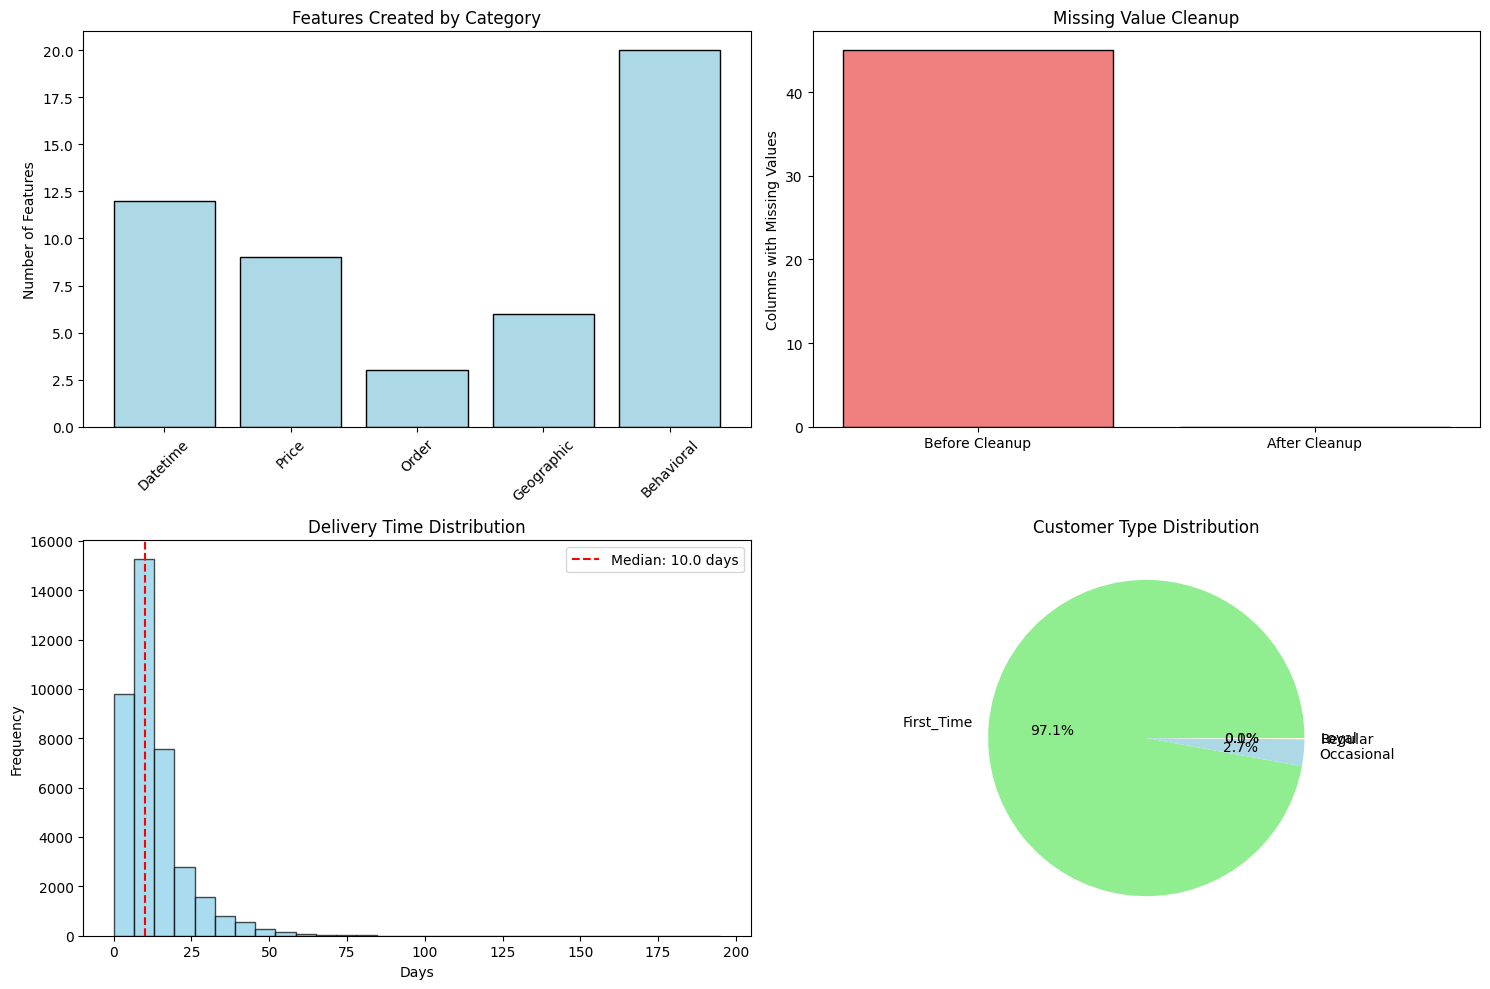


Feature engineering complete!
Final dataset shape: (38875, 101)

Sample of Key Engineered Features:


,sentiment_binary,delivery_time_days,delivered_late,price_tier,order_complexity_score,customer_type,seller_experience,same_state_delivery
4563,0,10.0,0,Mid,0,First_Time,New,0
4418,0,10.0,0,Low,1,First_Time,New,0
10128,0,10.0,0,Budget,1,First_Time,New,0
30868,0,54.0,1,High,0,First_Time,New,0
93797,1,23.0,0,Budget,0,First_Time,New,0


In [47]:
"""
Comprehensive feature engineering functionality
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def engineer_comprehensive_features(df):
    """
    Feature engineering including datetime, numerical, and categorical features
    """

    if df is None:
        print("No dataset provided")
        return None

    print("FEATURE ENGINEERING")
    print("="*70)

    df_features = df.copy()
    initial_features = len(df_features.columns)

    print(f"Starting with {initial_features} features")

    # 1. DATETIME FEATURE ENGINEERING
    datetime_columns = [
        'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
        'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_creation_date'
    ]

    # Convert datetime columns
    for col in datetime_columns:
        if col in df_features.columns:
            df_features[col] = pd.to_datetime(df_features[col], errors='coerce')

    # Extract features from purchase timestamp
    if 'order_purchase_timestamp' in df_features.columns:
        df_features['purchase_year'] = df_features['order_purchase_timestamp'].dt.year
        df_features['purchase_month'] = df_features['order_purchase_timestamp'].dt.month
        df_features['purchase_hour'] = df_features['order_purchase_timestamp'].dt.hour
        df_features['purchase_dayofweek'] = df_features['order_purchase_timestamp'].dt.dayofweek
        df_features['purchase_is_weekend'] = df_features['purchase_dayofweek'].isin([5, 6]).astype(int)

        df_features['purchase_business_hours'] = (
            (df_features['purchase_hour'] >= 9) & (df_features['purchase_hour'] <= 18)
        ).astype(int)

    # Calculate delivery performance metrics
    if all(col in df_features.columns for col in ['order_purchase_timestamp', 'order_delivered_customer_date']):
        df_features['delivery_time_days'] = (
            df_features['order_delivered_customer_date'] - df_features['order_purchase_timestamp']
        ).dt.days

        df_features['delivery_speed'] = pd.cut(
            df_features['delivery_time_days'],
            bins=[-float('inf'), 3, 7, 15, 30, float('inf')],
            labels=['Same_Week', 'Fast', 'Normal', 'Slow', 'Very_Slow']
        )

    # Delivery delay vs. estimate
    if all(col in df_features.columns for col in ['order_estimated_delivery_date', 'order_delivered_customer_date']):
        df_features['delivery_delay_days'] = (
            df_features['order_delivered_customer_date'] - df_features['order_estimated_delivery_date']
        ).dt.days

        df_features['delivered_early'] = (df_features['delivery_delay_days'] < 0).astype(int)
        df_features['delivered_late'] = (df_features['delivery_delay_days'] > 0).astype(int)

    # 2. PRICE AND VALUE ENGINEERING
    if 'total_price' in df_features.columns and 'total_freight' in df_features.columns:
        df_features['total_order_cost'] = df_features['total_price'] + df_features['total_freight']
        df_features['freight_percentage'] = (
            df_features['total_freight'] / (df_features['total_price'] + 0.01) * 100
        )

        df_features['price_tier'] = pd.qcut(
            df_features['total_price'].fillna(0),
            q=5,
            labels=['Budget', 'Low', 'Mid', 'High', 'Premium'],
            duplicates='drop'
        )

        df_features['expensive_shipping'] = (df_features['freight_percentage'] > 30).astype(int)
        df_features['free_shipping'] = (df_features['total_freight'] == 0).astype(int)

    # 3. ORDER COMPLEXITY FEATURES
    if 'total_items' in df_features.columns:
        df_features['is_single_item'] = (df_features['total_items'] == 1).astype(int)
        df_features['is_bulk_order'] = (df_features['total_items'] > 5).astype(int)

        complexity_factors = []

        if 'payment_methods_count' in df_features.columns:
            complexity_factors.append(df_features['payment_methods_count'] > 1)

        if 'uses_installments' in df_features.columns:
            complexity_factors.append(df_features['uses_installments'] == 1)

        complexity_factors.append(df_features['total_items'] > 3)

        if complexity_factors:
            df_features['order_complexity_score'] = sum(complexity_factors)

    # 4. GEOGRAPHIC FEATURES
    if 'customer_state' in df_features.columns:
        southeast_states = ['SP', 'RJ', 'MG', 'ES']
        south_states = ['RS', 'SC', 'PR']
        northeast_states = ['BA', 'PE', 'CE', 'PB', 'RN', 'AL', 'SE', 'MA', 'PI']

        df_features['customer_southeast'] = df_features['customer_state'].isin(southeast_states).astype(int)
        df_features['customer_south'] = df_features['customer_state'].isin(south_states).astype(int)
        df_features['customer_northeast'] = df_features['customer_state'].isin(northeast_states).astype(int)

    if all(col in df_features.columns for col in ['customer_state', 'seller_state']):
        df_features['same_state_delivery'] = (
            df_features['customer_state'] == df_features['seller_state']
        ).astype(int)

    # 5. SELLER PERFORMANCE FEATURES
    if 'primary_seller_id' in df_features.columns:
        if 'order_purchase_timestamp' in df_features.columns:
            df_features = df_features.sort_values('order_purchase_timestamp')
            df_features['seller_order_volume'] = df_features.groupby('primary_seller_id').cumcount()
        else:
            seller_order_counts = df_features['primary_seller_id'].value_counts()
            df_features['seller_order_volume'] = df_features['primary_seller_id'].map(seller_order_counts)

        df_features['seller_experience'] = pd.cut(
            df_features['seller_order_volume'].fillna(0),
            bins=[-1, 4, 19, 99, float('inf')],
            labels=['New', 'Developing', 'Experienced', 'Power_Seller']
        )

        df_features['is_power_seller'] = (df_features['seller_order_volume'] > 99).astype(int)

    # 6. CUSTOMER BEHAVIOR FEATURES
    if 'customer_unique_id' in df_features.columns:
        if 'order_purchase_timestamp' in df_features.columns:
            df_features = df_features.sort_values('order_purchase_timestamp')
            df_features['customer_order_count'] = df_features.groupby('customer_unique_id').cumcount()
        else:
            customer_order_counts = df_features['customer_unique_id'].value_counts()
            df_features['customer_order_count'] = df_features['customer_unique_id'].map(customer_order_counts)

        df_features['customer_type'] = pd.cut(
            df_features['customer_order_count'].fillna(0),
            bins=[-1, 0, 2, 9, float('inf')],
            labels=['First_Time', 'Occasional', 'Regular', 'Loyal']
        )

        df_features['is_repeat_customer'] = (df_features['customer_order_count'] > 0).astype(int)

    # 7. MISSING VALUE HANDLING
    missing_summary = df_features.isnull().sum()
    columns_with_missing = missing_summary[missing_summary > 0]

    if len(columns_with_missing) > 0:
        # Handle categorical columns
        categorical_cols = df_features.select_dtypes(include=['object', 'category']).columns
        for col in categorical_cols:
            if df_features[col].isnull().sum() > 0:
                if df_features[col].dtype.name == 'category':
                    if 'Unknown' not in df_features[col].cat.categories:
                        df_features[col] = df_features[col].cat.add_categories(['Unknown'])
                        df_features[col] = df_features[col].fillna('Unknown')
                    else:
                        df_features[col] = df_features[col].fillna('Unknown')

        # Handle numerical columns
        numerical_cols = df_features.select_dtypes(include=[np.number]).columns
        for col in numerical_cols:
            if df_features[col].isnull().sum() > 0:
                if any(keyword in col.lower() for keyword in ['count', 'volume', 'score']):
                    df_features[col] = df_features[col].fillna(0)
                else:
                    df_features[col] = df_features[col].fillna(df_features[col].median())

    # Final cleanup
    remaining_missing = df_features.isnull().sum().sum()
    if remaining_missing > 0:
        numerical_cols = df_features.select_dtypes(include=[np.number]).columns
        for col in numerical_cols:
            if df_features[col].isnull().sum() > 0:
                df_features[col] = df_features[col].fillna(df_features[col].median())

        categorical_cols = df_features.select_dtypes(include=['object', 'category']).columns
        for col in categorical_cols:
            if df_features[col].isnull().sum() > 0:
                if df_features[col].dtype.name == 'category':
                    if 'Unknown' not in df_features[col].cat.categories:
                        df_features[col] = df_features[col].cat.add_categories(['Unknown'])
                df_features[col] = df_features[col].fillna('Unknown')

    # Feature engineering summary
    new_features = len(df_features.columns) - initial_features
    final_missing = df_features.isnull().sum().sum()
    memory_mb = df_features.memory_usage(deep=True).sum() / 1024**2

    print(f"Feature Engineering Summary:")
    print(f"• Created {new_features} new features")
    print(f"• Total features: {len(df_features.columns)}")
    print(f"• Missing values: {final_missing}")
    print(f"• Memory usage: {memory_mb:.1f} MB")

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Feature creation by type
    feature_types = {
        'Datetime': len([col for col in df_features.columns if any(keyword in col.lower()
                        for keyword in ['purchase_', 'delivery_', 'hour', 'day', 'month', 'year'])]),
        'Price': len([col for col in df_features.columns if any(keyword in col.lower()
                     for keyword in ['price', 'cost', 'freight', 'tier'])]),
        'Order': len([col for col in df_features.columns if any(keyword in col.lower()
                     for keyword in ['single_item', 'bulk', 'complexity'])]),
        'Geographic': len([col for col in df_features.columns if any(keyword in col.lower()
                          for keyword in ['state', 'southeast', 'south', 'northeast'])]),
        'Behavioral': len([col for col in df_features.columns if any(keyword in col.lower()
                          for keyword in ['seller_', 'customer_', 'repeat', 'power'])])
    }

    axes[0,0].bar(feature_types.keys(), feature_types.values(), color='lightblue', edgecolor='black')
    axes[0,0].set_title('Features Created by Category')
    axes[0,0].set_ylabel('Number of Features')
    axes[0,0].tick_params(axis='x', rotation=45)

    # 2. Missing values before/after
    if len(columns_with_missing) > 0:
        before_after = [len(columns_with_missing), 0]
        axes[0,1].bar(['Before Cleanup', 'After Cleanup'], before_after,
                     color=['lightcoral', 'lightgreen'], edgecolor='black')
        axes[0,1].set_title('Missing Value Cleanup')
        axes[0,1].set_ylabel('Columns with Missing Values')
    else:
        axes[0,1].text(0.5, 0.5, 'No Missing Values\nFound',
                      ha='center', va='center', transform=axes[0,1].transAxes, fontsize=14)
        axes[0,1].set_title('Missing Value Status')

    # 3. Delivery performance distribution (if available)
    if 'delivery_time_days' in df_features.columns:
        delivery_times = df_features['delivery_time_days'].dropna()
        if len(delivery_times) > 0:
            axes[1,0].hist(delivery_times, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
            axes[1,0].set_title('Delivery Time Distribution')
            axes[1,0].set_xlabel('Days')
            axes[1,0].set_ylabel('Frequency')
            axes[1,0].axvline(delivery_times.median(), color='red', linestyle='--',
                             label=f'Median: {delivery_times.median():.1f} days')
            axes[1,0].legend()
    else:
        axes[1,0].text(0.5, 0.5, 'Delivery Time\nData Not Available',
                      ha='center', va='center', transform=axes[1,0].transAxes, fontsize=12)
        axes[1,0].set_title('Delivery Performance')

    # 4. Customer type distribution (if available)
    if 'customer_type' in df_features.columns:
        customer_dist = df_features['customer_type'].value_counts()
        axes[1,1].pie(customer_dist.values, labels=customer_dist.index, autopct='%1.1f%%',
                     colors=['lightgreen', 'lightblue', 'lightyellow', 'lightcoral'])
        axes[1,1].set_title('Customer Type Distribution')
    else:
        axes[1,1].text(0.5, 0.5, 'Customer Type\nData Not Available',
                      ha='center', va='center', transform=axes[1,1].transAxes, fontsize=12)
        axes[1,1].set_title('Customer Segmentation')

    plt.tight_layout()
    plt.show()

    return df_features


# Apply comprehensive feature engineering
print("Starting comprehensive feature engineering...\n")
df_engineered = engineer_comprehensive_features(df_with_text)

if df_engineered is not None:
    print(f"\nFeature engineering complete!")
    print(f"Final dataset shape: {df_engineered.shape}")

    # Sample of key engineered features
    if 'sentiment_binary' in df_engineered.columns:
        key_features = []
        potential_features = ['sentiment_binary', 'delivery_time_days', 'delivered_late', 'price_tier',
                            'order_complexity_score', 'customer_type', 'seller_experience', 'same_state_delivery']

        for feature in potential_features:
            if feature in df_engineered.columns:
                key_features.append(feature)

        if key_features:
            print(f"\nSample of Key Engineered Features:")
            sample = df_engineered[key_features].head(5)
            display(sample)

else:
    print("Feature engineering failed")

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

Starting model building and evaluation...

BUILDING CLASSIFICATION MODELS WITH AUTOMATIC FEATURE SELECTION
Samples with target: 38,875
Total potential features: 80
Final dataset: 38,875 samples, 80 features
Class distribution: 10,975 negative, 27,900 positive
Selected 25 features for modeling

MODEL PERFORMANCE:
Logistic Regression:
  Accuracy: 0.8387
  Macro F1: 0.7866
  Weighted F1: 0.8325
Random Forest:
  Accuracy: 0.8481
  Macro F1: 0.7986
  Weighted F1: 0.8421
Gradient Boosting:
  Accuracy: 0.8540
  Macro F1: 0.8112
  Weighted F1: 0.8503

Best Model: Gradient Boosting
Macro F1-Score: 0.8112
Accuracy: 0.8540


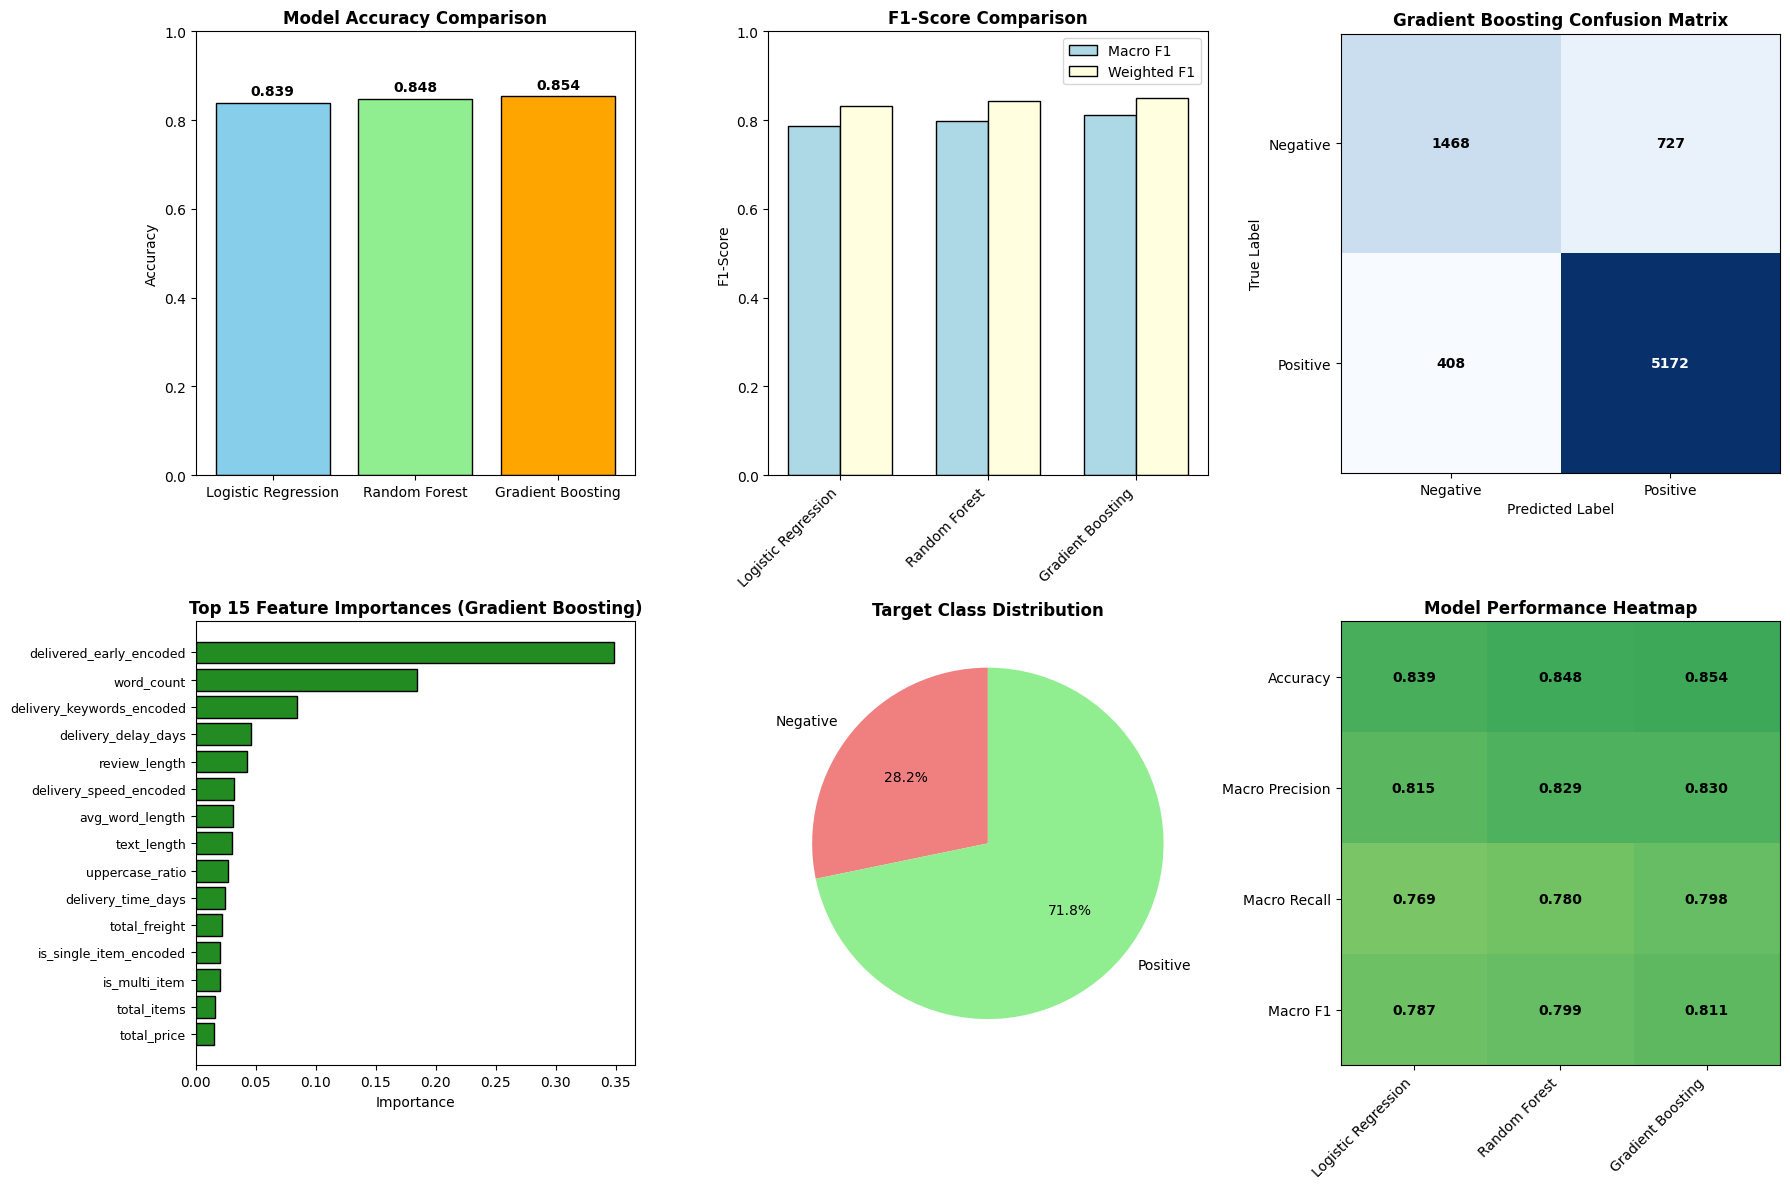


Top 10 Most Important Features (Gradient Boosting):
 1. delivered_early_encoded: 0.3487
 2. word_count: 0.1845
 3. delivery_keywords_encoded: 0.0848
 4. delivery_delay_days: 0.0461
 5. review_length: 0.0428
 6. delivery_speed_encoded: 0.0321
 7. avg_word_length: 0.0314
 8. text_length: 0.0302
 9. uppercase_ratio: 0.0265
10. delivery_time_days: 0.0243

Model building complete!
Best model: Gradient Boosting
Features used: 25

Sample Predictions:


,Actual,Predicted,Probability
0,1,1,0.791
1,1,1,0.976
2,1,1,0.894
3,0,1,0.549
4,1,0,0.187
5,0,0,0.063
6,1,1,0.895
7,1,1,0.988
8,1,1,0.885
9,1,1,0.948


In [49]:

def build_classification_models(df):
    """
    Build and evaluate multiple classification models with automatic feature selection
    """

    if df is None:
        print("No dataset provided")
        return None

    print("BUILDING CLASSIFICATION MODELS WITH AUTOMATIC FEATURE SELECTION")
    print("="*70)

    # Filter to samples with target variable
    modeling_df = df[df['sentiment_binary'].notna()].copy()
    print(f"Samples with target: {len(modeling_df):,}")

    if len(modeling_df) == 0:
        print("No samples with target variable!")
        return None

    # Identify all potential features (exclude target, ID columns, and datetime columns)
    exclude_columns = [
        'sentiment_binary', 'review_id', 'order_id', 'customer_unique_id', 'product_id',
        'review_score',
        'sentiment_aggressive', 'sentiment_ultra', 'sentiment_keyword_ratio',
        'sentiment_positive', 'sentiment_negative',
        'review_comment_message', 'review_comment_title', 'review_text_combined',
        'review_text_cleaned',
        'positive_keywords', 'negative_keywords'
    ]
    potential_features = [col for col in modeling_df.columns if col not in exclude_columns]

    # Remove datetime columns
    datetime_columns = []
    for col in potential_features:
        if pd.api.types.is_datetime64_any_dtype(modeling_df[col]):
            datetime_columns.append(col)

    potential_features = [col for col in potential_features if col not in datetime_columns]

    print(f"Total potential features: {len(potential_features)}")

    # Separate numerical and categorical features automatically
    numerical_features = []
    categorical_features = []

    for feature in potential_features:
        if modeling_df[feature].dtype in ['int64', 'float64', 'int32', 'float32']:
            if modeling_df[feature].nunique() > 10 or modeling_df[feature].dtype in ['float64', 'float32']:
                numerical_features.append(feature)
            else:
                categorical_features.append(feature)
        else:
            categorical_features.append(feature)

    # Handle missing values
    for feature in numerical_features:
        if modeling_df[feature].isnull().sum() > 0:
            median_value = modeling_df[feature].median()
            modeling_df[feature] = modeling_df[feature].fillna(median_value)

    for feature in categorical_features:
        if modeling_df[feature].isnull().sum() > 0:
            mode_value = modeling_df[feature].mode().iloc[0] if len(modeling_df[feature].mode()) > 0 else 'Unknown'
            modeling_df[feature] = modeling_df[feature].fillna(mode_value)

    # Encode categorical features
    label_encoders = {}
    encoded_features = []

    for feature in categorical_features:
        le = LabelEncoder()
        try:
            modeling_df[f'{feature}_encoded'] = le.fit_transform(modeling_df[feature].astype(str))
            label_encoders[feature] = le
            encoded_features.append(f'{feature}_encoded')
        except Exception as e:
            print(f"Failed to encode {feature}: {e}")

    # Combine all features
    all_features = numerical_features + encoded_features
    all_features = [f for f in all_features if f in modeling_df.columns]

    # Prepare X and y
    X = modeling_df[all_features].copy()
    y = modeling_df['sentiment_binary'].copy()

    print(f"Final dataset: {len(X):,} samples, {len(all_features)} features")
    print(f"Class distribution: {(y == 0).sum():,} negative, {(y == 1).sum():,} positive")

    # Handle remaining missing values
    X = X.fillna(X.median(numeric_only=True))

    # Remove low-variance features
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    feature_variances = X[numeric_cols].var()
    low_variance_features = feature_variances[feature_variances < 0.01].index.tolist()

    if low_variance_features:
        X = X.drop(columns=low_variance_features)
        all_features = [f for f in all_features if f not in low_variance_features]

    # Ensure all features are numeric
    non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns
    if len(non_numeric_cols) > 0:
        for col in non_numeric_cols:
            try:
                X[col] = pd.to_numeric(X[col], errors='coerce')
                X[col] = X[col].fillna(X[col].median())
            except:
                X = X.drop(columns=[col])
                all_features = [f for f in all_features if f != col]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    # Automatic feature selection
    n_features_to_select = min(len(X_train.columns), 25)
    selector = SelectKBest(score_func=f_classif, k=n_features_to_select)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)

    selected_features = X_train_scaled.columns[selector.get_support()].tolist()
    X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train.index)
    X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features, index=X_test.index)

    print(f"Selected {len(selected_features)} features for modeling")

    # Define models
    models = {
        'Logistic Regression': LogisticRegression(
            C=0.1, penalty='l2', solver='liblinear', random_state=42, max_iter=1000
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100, max_depth=10, min_samples_split=10,
            min_samples_leaf=2, random_state=42
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100, learning_rate=0.1, max_depth=6,
            subsample=0.8, random_state=42
        )
    }

    results = {}
    feature_importance = {}

    # Train models
    for model_name, model in models.items():
        if model_name == 'Logistic Regression':
            model.fit(X_train_selected, y_train)
            y_pred = model.predict(X_test_selected)
            y_prob = model.predict_proba(X_test_selected)[:, 1]

            feature_importance[model_name] = pd.Series(
                np.abs(model.coef_[0]),
                index=selected_features
            ).sort_values(ascending=False)

        else:
            X_train_tree = X_train[selected_features]
            X_test_tree = X_test[selected_features]

            model.fit(X_train_tree, y_train)
            y_pred = model.predict(X_test_tree)
            y_prob = model.predict_proba(X_test_tree)[:, 1]

            feature_importance[model_name] = pd.Series(
                model.feature_importances_,
                index=selected_features
            ).sort_values(ascending=False)

        results[model_name] = {
            'predictions': y_pred,
            'probabilities': y_prob,
            'accuracy': accuracy_score(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred, output_dict=True)
        }

    # Model evaluation results
    print("\nMODEL PERFORMANCE:")
    for model_name, result in results.items():
        cr = result['classification_report']
        print(f"{model_name}:")
        print(f"  Accuracy: {result['accuracy']:.4f}")
        print(f"  Macro F1: {cr['macro avg']['f1-score']:.4f}")
        print(f"  Weighted F1: {cr['weighted avg']['f1-score']:.4f}")

    # Best model selection
    best_model_name = max(results.keys(), key=lambda x: results[x]['classification_report']['macro avg']['f1-score'])
    best_model = models[best_model_name]
    best_result = results[best_model_name]

    print(f"\nBest Model: {best_model_name}")
    print(f"Macro F1-Score: {best_result['classification_report']['macro avg']['f1-score']:.4f}")
    print(f"Accuracy: {best_result['accuracy']:.4f}")

    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Model accuracy comparison
    model_names = list(results.keys())
    accuracies = [results[name]['accuracy'] for name in model_names]

    axes[0,0].bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'orange'], edgecolor='black')
    axes[0,0].set_title('Model Accuracy Comparison', fontweight='bold')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].set_ylim(0, 1)

    for i, acc in enumerate(accuracies):
        axes[0,0].text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

    # 2. F1-Score comparison
    f1_macro = [results[name]['classification_report']['macro avg']['f1-score'] for name in model_names]
    f1_weighted = [results[name]['classification_report']['weighted avg']['f1-score'] for name in model_names]

    x = np.arange(len(model_names))
    width = 0.35

    axes[0,1].bar(x - width/2, f1_macro, width, label='Macro F1', color='lightblue', edgecolor='black')
    axes[0,1].bar(x + width/2, f1_weighted, width, label='Weighted F1', color='lightyellow', edgecolor='black')
    axes[0,1].set_title('F1-Score Comparison', fontweight='bold')
    axes[0,1].set_ylabel('F1-Score')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(model_names, rotation=45, ha='right')
    axes[0,1].legend()
    axes[0,1].set_ylim(0, 1)

    # 3. Best model confusion matrix
    cm = confusion_matrix(y_test, best_result['predictions'])
    im = axes[0,2].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[0,2].set_title(f'{best_model_name} Confusion Matrix', fontweight='bold')

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        axes[0,2].text(j, i, format(cm[i, j], 'd'),
                       ha="center", va="center",
                       color="white" if cm[i, j] > thresh else "black",
                       fontweight='bold')

    axes[0,2].set_ylabel('True Label')
    axes[0,2].set_xlabel('Predicted Label')
    axes[0,2].set_xticks([0, 1])
    axes[0,2].set_yticks([0, 1])
    axes[0,2].set_xticklabels(['Negative', 'Positive'])
    axes[0,2].set_yticklabels(['Negative', 'Positive'])

    # 4. Feature importance
    top_features = feature_importance[best_model_name].head(15)
    axes[1,0].barh(range(len(top_features)), top_features.values, color='forestgreen', edgecolor='black')
    axes[1,0].set_title(f'Top 15 Feature Importances ({best_model_name})', fontweight='bold')
    axes[1,0].set_xlabel('Importance')
    axes[1,0].set_yticks(range(len(top_features)))
    axes[1,0].set_yticklabels(top_features.index, fontsize=9)
    axes[1,0].invert_yaxis()

    # 5. Class distribution
    class_dist = y.value_counts().sort_index()
    axes[1,1].pie(class_dist.values, labels=['Negative', 'Positive'], autopct='%1.1f%%',
                  colors=['lightcoral', 'lightgreen'], startangle=90)
    axes[1,1].set_title('Target Class Distribution', fontweight='bold')

    # 6. Model performance heatmap
    performance_metrics = []
    for model_name in model_names:
        cr = results[model_name]['classification_report']
        performance_metrics.append([
            results[model_name]['accuracy'],
            cr['macro avg']['precision'],
            cr['macro avg']['recall'],
            cr['macro avg']['f1-score']
        ])

    performance_array = np.array(performance_metrics)
    metric_names = ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1']

    im = axes[1,2].imshow(performance_array.T, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    axes[1,2].set_title('Model Performance Heatmap', fontweight='bold')
    axes[1,2].set_xticks(range(len(model_names)))
    axes[1,2].set_yticks(range(len(metric_names)))
    axes[1,2].set_xticklabels(model_names, rotation=45, ha='right')
    axes[1,2].set_yticklabels(metric_names)

    for i in range(len(metric_names)):
        for j in range(len(model_names)):
            axes[1,2].text(j, i, f'{performance_array[j, i]:.3f}',
                          ha="center", va="center", color="black", fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Feature importance summary
    print(f"\nTop 10 Most Important Features ({best_model_name}):")
    for i, (feature, importance) in enumerate(feature_importance[best_model_name].head(10).items()):
        print(f"{i+1:2d}. {feature}: {importance:.4f}")

    # Return results
    modeling_results = {
        'models': models,
        'results': results,
        'best_model': best_model,
        'best_model_name': best_model_name,
        'selected_features': selected_features,
        'feature_selector': selector,
        'feature_importance': feature_importance,
        'label_encoders': label_encoders,
        'scaler': scaler,
        'X_test': X_test,
        'y_test': y_test,
        'test_predictions': best_result['predictions'],
        'test_probabilities': best_result['probabilities']
    }

    return modeling_results

# Build and evaluate models
print("Starting model building and evaluation...\n")
model_results = build_classification_models(df_engineered)

if model_results is not None:
    print(f"\nModel building complete!")
    print(f"Best model: {model_results['best_model_name']}")
    print(f"Features used: {len(model_results['selected_features'])}")

    # Sample predictions
    print(f"\nSample Predictions:")
    sample_predictions = pd.DataFrame({
        'Actual': model_results['y_test'].head(10).values,
        'Predicted': model_results['test_predictions'][:10],
        'Probability': model_results['test_probabilities'][:10].round(3)
    })
    display(sample_predictions)
else:
    print("Model building failed")

🚀 Starting bonus challenge: Sentiment reason extraction...

BONUS CHALLENGE: SENTIMENT REASON EXTRACTION
Goal: Extract structured reasons that make reviews positive or negative
Examples: delivery time issues, product quality, seller service, price/value

Text samples available: 38,875

DEFINING REASON CATEGORIES:
Defined 6 reason categories:
     • delivery_time: 16 positive + 16 negative keywords
     • product_quality: 15 positive + 17 negative keywords
     • seller_service: 15 positive + 13 negative keywords
     • price_value: 14 positive + 14 negative keywords
     • product_description: 9 positive + 10 negative keywords
     • general_satisfaction: 11 positive + 9 negative keywords

EXTRACTING REASONS FROM REVIEW TEXTS:
Processing review texts...
Reason extraction complete!

REASON PATTERN ANALYSIS:
delivery_time: 12,060 mentions (31.0%)
product_quality: 9,952 mentions (25.6%)
seller_service: 2,372 mentions (6.1%)
price_value: 1,413 mentions (3.6%)
product_description: 1,850 men

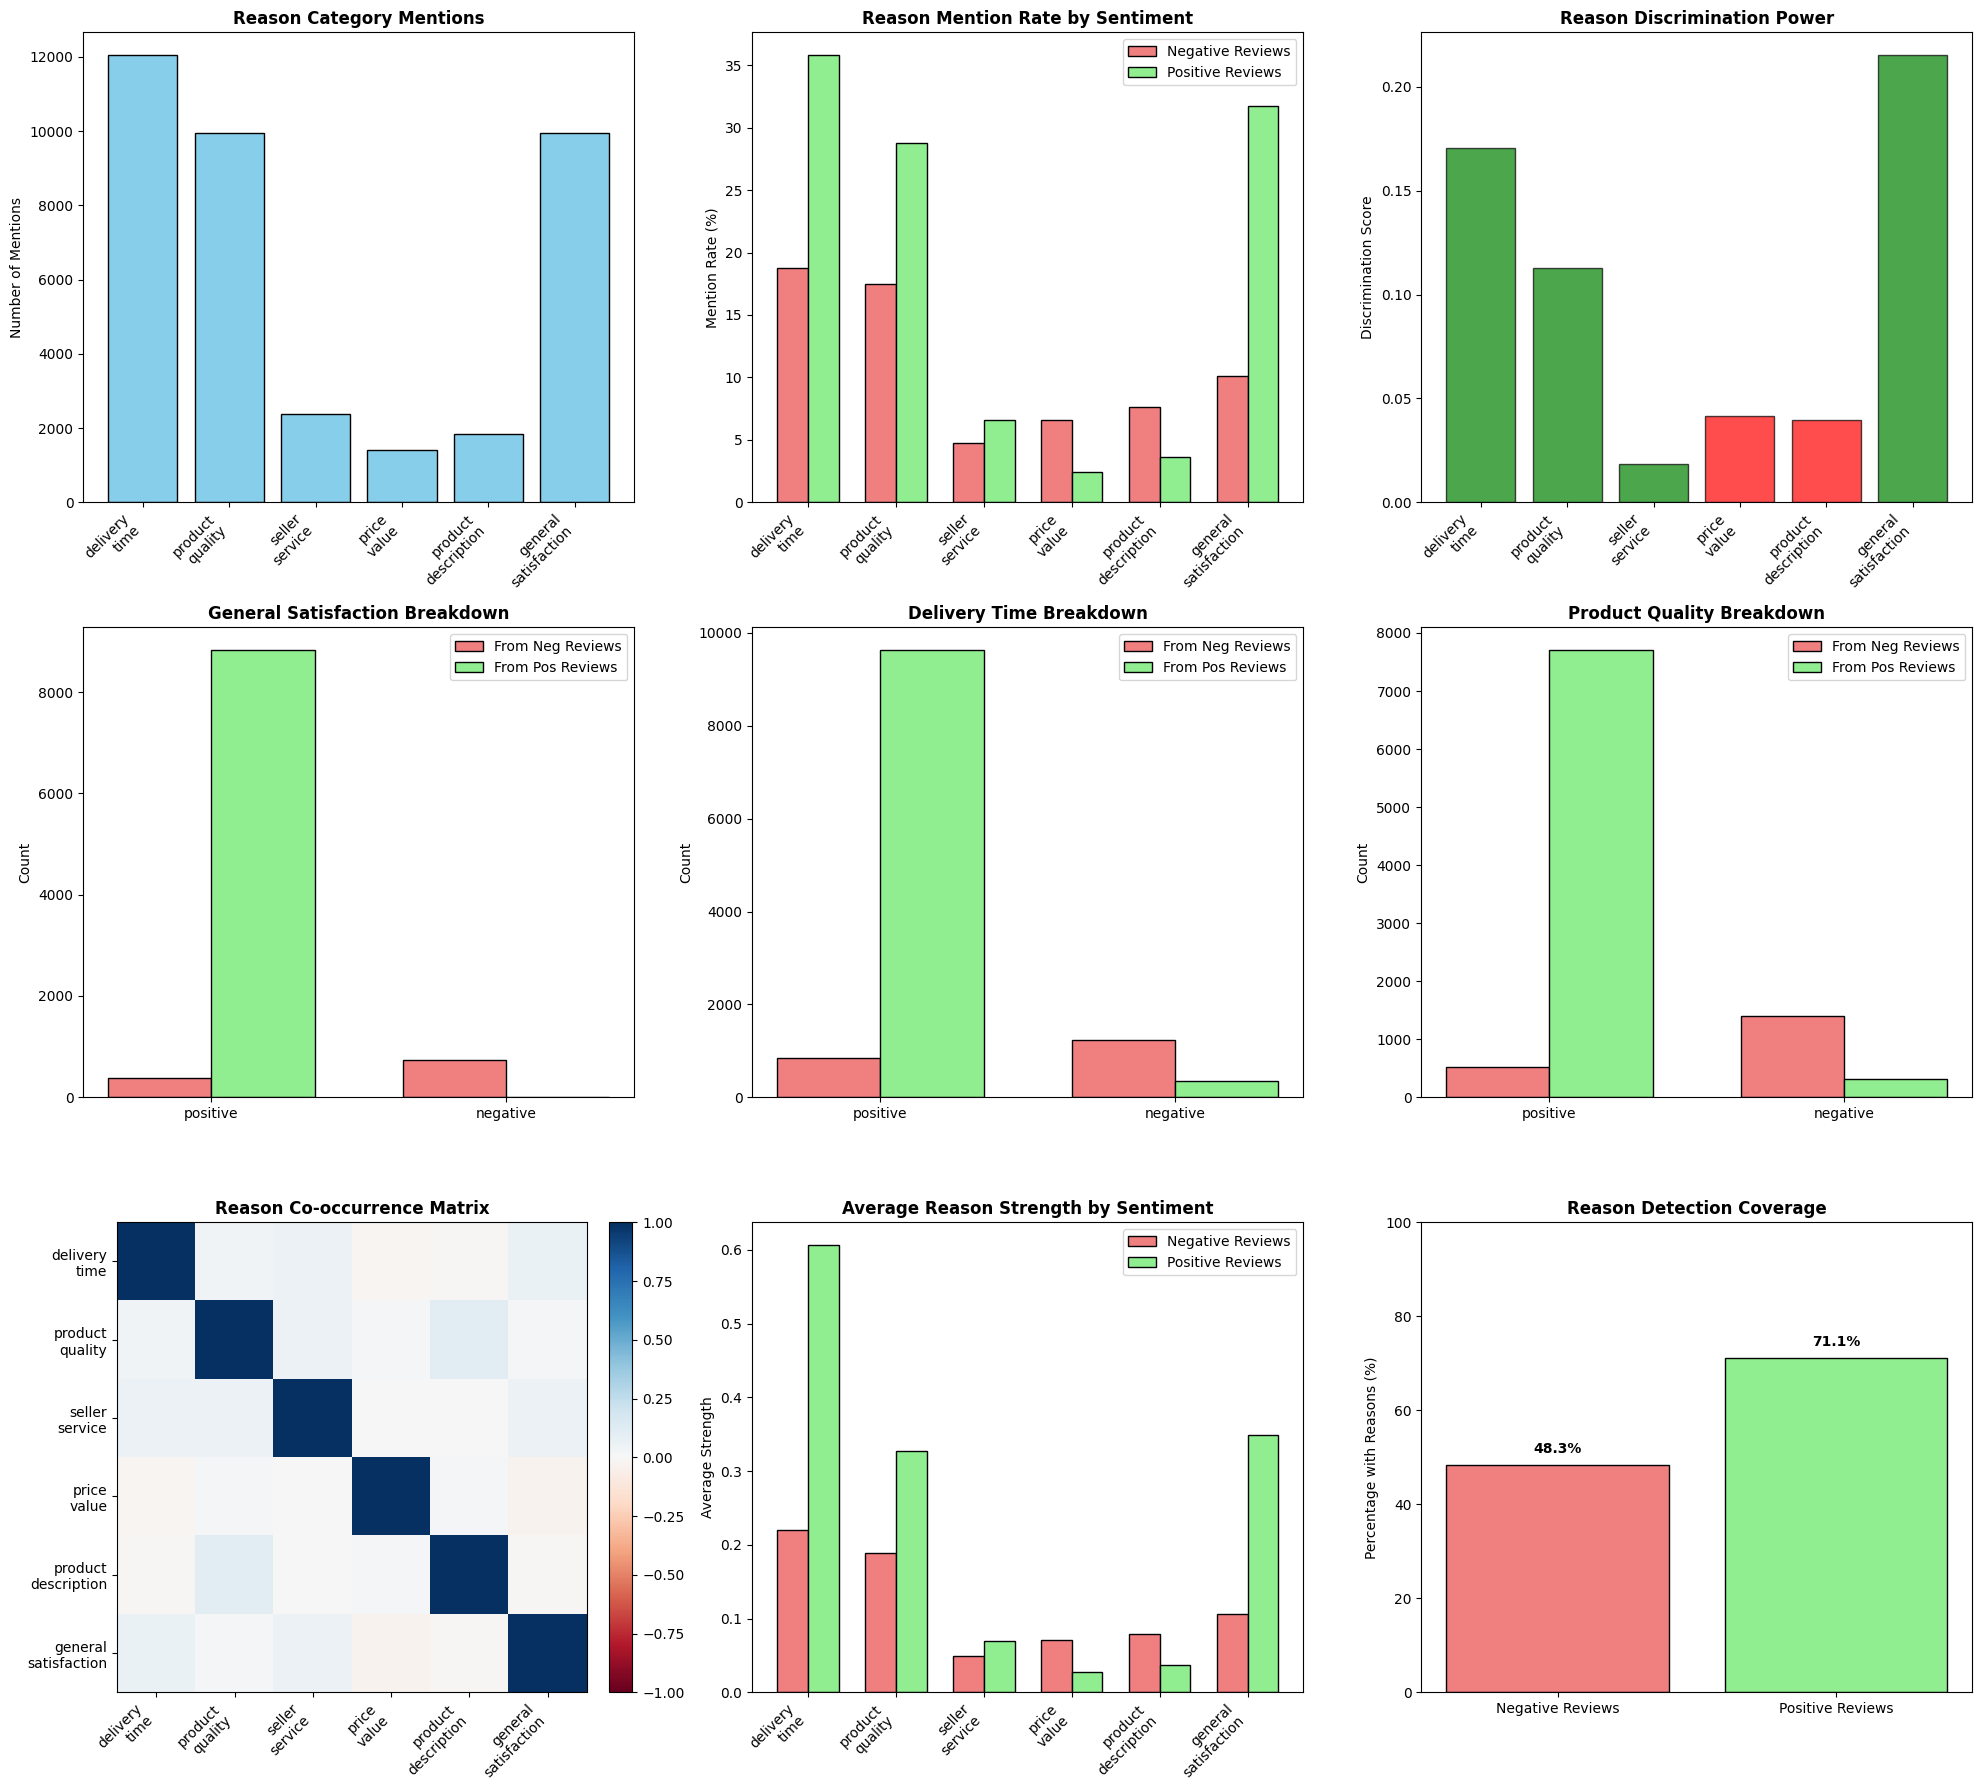


SENTIMENT REASON EXTRACTION COMPLETE!
Summary:
Total reviews analyzed: 38,875
Reviews with detected reasons: 25,128 (64.6%)
Reason categories: 6
Most discriminative reason: general_satisfaction (score: 0.215)

 BONUS CHALLENGE IMPLEMENTED!
Structured insights into WHY customers give positive/negative reviews!

BONUS CHALLENGE COMPLETED!


In [50]:
def extract_sentiment_reasons(df, model_results):
    """
    BONUS CHALLENGE: Extract structured reasons for positive/negative sentiment
    This addresses the key differentiator mentioned in the challenge description
    """

    if df is None or model_results is None:
        print("Missing required inputs")
        return None

    print("BONUS CHALLENGE: SENTIMENT REASON EXTRACTION")
    print("="*70)
    print("Goal: Extract structured reasons that make reviews positive or negative")
    print("Examples: delivery time issues, product quality, seller service, price/value")

    # Filter to samples with text reviews
    text_df = df[df['review_text_cleaned'].notna()].copy()
    print(f"\nText samples available: {len(text_df):,}")

    if len(text_df) == 0:
        print("No text samples available for reason extraction")
        return None

    # Define reason categories and keywords (expanded Portuguese keywords)
    print(f"\nDEFINING REASON CATEGORIES:")

    reason_categories = {
        'delivery_time': {
            'positive': [
                'rápido', 'rapidez', 'rápida', 'veloz', 'agilidade', 'pontual', 'prazo',
                'chegou rápido', 'entrega rápida', 'super rápido', 'em tempo', 'no prazo',
                'antes do prazo', 'antecipou', 'entrega express', 'delivery'
            ],
            'negative': [
                'demorou', 'atrasou', 'atraso', 'demora', 'lento', 'lenta', 'devagar',
                'não chegou', 'perdido', 'extraviado', 'prazo vencido', 'muito tempo',
                'semanas', 'meses', 'nunca chegou', 'onde está'
            ]
        },
        'product_quality': {
            'positive': [
                'qualidade', 'excelente', 'perfeito', 'ótimo', 'maravilhoso', 'resistente',
                'durável', 'bem feito', 'acabamento', 'material bom', 'como descrito',
                'conforme anúncio', 'igual foto', 'superou expectativa', 'original'
            ],
            'negative': [
                'defeito', 'quebrado', 'danificado', 'ruim', 'péssimo', 'frágil',
                'barato', 'mal feito', 'diferente', 'não confere', 'falsificado',
                'china', 'usado', 'arranhado', 'sujo', 'velho', 'mentira'
            ]
        },
        'seller_service': {
            'positive': [
                'atendimento', 'educado', 'prestativo', 'cortês', 'ajudou', 'respondeu',
                'atenção', 'cuidado', 'embalagem', 'bem embalado', 'capricho',
                'profissional', 'recomendo loja', 'vendedor bom', 'suporte'
            ],
            'negative': [
                'não respondeu', 'ignorou', 'mal educado', 'grosso', 'mal atendimento',
                'sem educação', 'não ajudou', 'problema comunicação', 'mal embalado',
                'sem cuidado', 'jogado', 'amassado', 'loja ruim'
            ]
        },
        'price_value': {
            'positive': [
                'barato', 'bom preço', 'vale pena', 'custo benefício', 'promoção',
                'desconto', 'oferta', 'preço justo', 'econômico', 'em conta',
                'compensou', 'investimento', 'valor', 'vantajoso'
            ],
            'negative': [
                'caro', 'cara', 'preço alto', 'muito caro', 'não vale', 'caro demais',
                'frete caro', 'enganação', 'roubo', 'abusivo', 'superfaturado',
                'melhor preço', 'mais barato', 'encontrei menor'
            ]
        },
        'product_description': {
            'positive': [
                'como descrito', 'conforme anúncio', 'igual foto', 'descrição correta',
                'exatamente', 'certinho', 'como esperado', 'fidedigno', 'compatível'
            ],
            'negative': [
                'diferente', 'não confere', 'mentira', 'propaganda enganosa', 'fake',
                'outra coisa', 'não é isso', 'errado', 'incompatível', 'não serve'
            ]
        },
        'general_satisfaction': {
            'positive': [
                'satisfeito', 'feliz', 'adorei', 'amei', 'gostei', 'aprovado',
                'recomendo', 'compro novamente', 'indicaria', 'voltarei', 'nota 10'
            ],
            'negative': [
                'decepcionado', 'arrependido', 'insatisfeito', 'não gostei', 'odeio',
                'não recomendo', 'não compro mais', 'experiência ruim', 'nunca mais'
            ]
        }
    }

    print(f"Defined {len(reason_categories)} reason categories:")
    for category in reason_categories.keys():
        pos_count = len(reason_categories[category]['positive'])
        neg_count = len(reason_categories[category]['negative'])
        print(f"     • {category}: {pos_count} positive + {neg_count} negative keywords")

    # Extract reasons for each review
    print(f"\nEXTRACTING REASONS FROM REVIEW TEXTS:")

    def extract_reasons_from_text(text, sentiment):
        """Extract specific reasons from review text"""
        if pd.isna(text) or text == "":
            return {}

        text_lower = str(text).lower()
        detected_reasons = {}

        for category, keywords in reason_categories.items():
            # Count positive and negative keywords for this category
            pos_matches = sum(1 for keyword in keywords['positive'] if keyword in text_lower)
            neg_matches = sum(1 for keyword in keywords['negative'] if keyword in text_lower)

            # Determine if this category is mentioned and its sentiment
            if pos_matches > 0 or neg_matches > 0:
                # Primary sentiment for this category
                if pos_matches > neg_matches:
                    category_sentiment = 'positive'
                    strength = pos_matches
                elif neg_matches > pos_matches:
                    category_sentiment = 'negative'
                    strength = neg_matches
                else:
                    # Tie - use overall review sentiment
                    category_sentiment = 'positive' if sentiment == 1 else 'negative'
                    strength = max(pos_matches, neg_matches)

                detected_reasons[category] = {
                    'sentiment': category_sentiment,
                    'strength': strength,
                    'positive_matches': pos_matches,
                    'negative_matches': neg_matches
                }

        return detected_reasons

    # Apply reason extraction
    print("Processing review texts...")

    text_df['extracted_reasons'] = text_df.apply(
        lambda row: extract_reasons_from_text(row['review_text_cleaned'], row['sentiment_binary']),
        axis=1
    )

    # Create structured reason features
    for category in reason_categories.keys():
        text_df[f'mentions_{category}'] = text_df['extracted_reasons'].apply(
            lambda x: 1 if category in x else 0
        )
        text_df[f'{category}_sentiment'] = text_df['extracted_reasons'].apply(
            lambda x: x[category]['sentiment'] if category in x else None
        )
        text_df[f'{category}_strength'] = text_df['extracted_reasons'].apply(
            lambda x: x[category]['strength'] if category in x else 0
        )

    print("Reason extraction complete!")

    # Analyze reason patterns
    print(f"\nREASON PATTERN ANALYSIS:")

    # Overall reason mention frequency
    reason_mentions = {}
    for category in reason_categories.keys():
        mentions = text_df[f'mentions_{category}'].sum()
        percentage = mentions / len(text_df) * 100
        reason_mentions[category] = {
            'count': mentions,
            'percentage': percentage
        }
        print(f"{category}: {mentions:,} mentions ({percentage:.1f}%)")

    # Reason distribution by sentiment
    print(f"\nREASON DISTRIBUTION BY OVERALL SENTIMENT:")

    sentiment_reason_analysis = {}

    for sentiment_label, sentiment_name in [(0, 'Negative'), (1, 'Positive')]:
        sentiment_subset = text_df[text_df['sentiment_binary'] == sentiment_label]
        print(f"\n   {sentiment_name} Reviews ({len(sentiment_subset):,} samples):")

        sentiment_reason_analysis[sentiment_name] = {}

        for category in reason_categories.keys():
            mentions = sentiment_subset[f'mentions_{category}'].sum()
            if len(sentiment_subset) > 0:
                percentage = mentions / len(sentiment_subset) * 100

                # Analyze sentiment within category
                category_sentiment_counts = sentiment_subset[f'{category}_sentiment'].value_counts()

                sentiment_reason_analysis[sentiment_name][category] = {
                    'mentions': mentions,
                    'percentage': percentage,
                    'sentiment_breakdown': category_sentiment_counts.to_dict()
                }

                print(f"     • {category}: {mentions} ({percentage:.1f}%)")
                if len(category_sentiment_counts) > 0:
                    for cat_sent, count in category_sentiment_counts.items():
                        if cat_sent:
                            print(f"       - {cat_sent}: {count}")

    # Identify most discriminative reasons
    print(f"\nMOST DISCRIMINATIVE REASONS:")

    discriminative_analysis = {}

    for category in reason_categories.keys():
        # Calculate mention rates for positive and negative reviews
        pos_reviews = text_df[text_df['sentiment_binary'] == 1]
        neg_reviews = text_df[text_df['sentiment_binary'] == 0]

        pos_mention_rate = pos_reviews[f'mentions_{category}'].mean() if len(pos_reviews) > 0 else 0
        neg_mention_rate = neg_reviews[f'mentions_{category}'].mean() if len(neg_reviews) > 0 else 0

        # Calculate discrimination score (difference in mention rates)
        discrimination_score = abs(pos_mention_rate - neg_mention_rate)

        discriminative_analysis[category] = {
            'pos_mention_rate': pos_mention_rate,
            'neg_mention_rate': neg_mention_rate,
            'discrimination_score': discrimination_score,
            'favors': 'positive' if pos_mention_rate > neg_mention_rate else 'negative'
        }

        print(f"{category}:")
        print(f"Positive reviews: {pos_mention_rate:.1%}")
        print(f"Negative reviews: {neg_mention_rate:.1%}")
        print(f"Discrimination: {discrimination_score:.3f} (favors {discriminative_analysis[category]['favors']})")

    # Find most impactful reasons
    top_discriminative = sorted(discriminative_analysis.items(),
                               key=lambda x: x[1]['discrimination_score'],
                               reverse=True)

    print(f"\nTOP 3 MOST DISCRIMINATIVE REASON CATEGORIES:")
    for i, (category, analysis) in enumerate(top_discriminative[:3]):
        print(f"   {i+1}. {category}: {analysis['discrimination_score']:.3f} (favors {analysis['favors']})")

    # Generate example extractions
    print(f"\EXAMPLE REASON EXTRACTIONS:")

    # Find good examples
    examples_found = 0
    for idx, row in text_df.head(100).iterrows():  # Check first 100 for examples
        if examples_found >= 6:  # Limit examples
            break

        reasons = row['extracted_reasons']
        if len(reasons) > 0:
            sentiment_label = "Positive" if row['sentiment_binary'] == 1 else "Negative"
            text_sample = row['review_text_cleaned'][:150] + "..." if len(row['review_text_cleaned']) > 150 else row['review_text_cleaned']

            print(f"\nExample {examples_found + 1} ({sentiment_label}):")
            print(f"Text: \"{text_sample}\"")
            print(f"Reasons detected:")

            for category, details in reasons.items():
                print(f"        • {category}: {details['sentiment']} (strength: {details['strength']})")

            examples_found += 1

    # Comprehensive visualization
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))

    # 1. Overall reason mention frequency
    categories = list(reason_mentions.keys())
    mention_counts = [reason_mentions[cat]['count'] for cat in categories]

    axes[0,0].bar(range(len(categories)), mention_counts, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Reason Category Mentions', fontweight='bold')
    axes[0,0].set_ylabel('Number of Mentions')
    axes[0,0].set_xticks(range(len(categories)))
    axes[0,0].set_xticklabels([cat.replace('_', '\n') for cat in categories], rotation=45, ha='right')

    # 2. Mention percentage by sentiment
    pos_rates = [discriminative_analysis[cat]['pos_mention_rate'] * 100 for cat in categories]
    neg_rates = [discriminative_analysis[cat]['neg_mention_rate'] * 100 for cat in categories]

    x = np.arange(len(categories))
    width = 0.35

    axes[0,1].bar(x - width/2, neg_rates, width, label='Negative Reviews', color='lightcoral', edgecolor='black')
    axes[0,1].bar(x + width/2, pos_rates, width, label='Positive Reviews', color='lightgreen', edgecolor='black')
    axes[0,1].set_title('Reason Mention Rate by Sentiment', fontweight='bold')
    axes[0,1].set_ylabel('Mention Rate (%)')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels([cat.replace('_', '\n') for cat in categories], rotation=45, ha='right')
    axes[0,1].legend()

    # 3. Discrimination scores
    discrimination_scores = [discriminative_analysis[cat]['discrimination_score'] for cat in categories]
    colors = ['red' if discriminative_analysis[cat]['favors'] == 'negative' else 'green' for cat in categories]

    axes[0,2].bar(range(len(categories)), discrimination_scores, color=colors, alpha=0.7, edgecolor='black')
    axes[0,2].set_title('Reason Discrimination Power', fontweight='bold')
    axes[0,2].set_ylabel('Discrimination Score')
    axes[0,2].set_xticks(range(len(categories)))
    axes[0,2].set_xticklabels([cat.replace('_', '\n') for cat in categories], rotation=45, ha='right')

    # 4-6. Individual category breakdowns (top 3 discriminative)
    for i, (category, _) in enumerate(top_discriminative[:3]):
        row = 1 + i // 3
        col = i % 3

        # Get sentiment breakdown for this category
        pos_subset = text_df[(text_df['sentiment_binary'] == 1) & (text_df[f'mentions_{category}'] == 1)]
        neg_subset = text_df[(text_df['sentiment_binary'] == 0) & (text_df[f'mentions_{category}'] == 1)]

        if len(pos_subset) > 0:
            pos_cat_sentiment = pos_subset[f'{category}_sentiment'].value_counts()
        else:
            pos_cat_sentiment = pd.Series()

        if len(neg_subset) > 0:
            neg_cat_sentiment = neg_subset[f'{category}_sentiment'].value_counts()
        else:
            neg_cat_sentiment = pd.Series()

        # Combine data for plotting
        all_sentiments = list(set(list(pos_cat_sentiment.index) + list(neg_cat_sentiment.index)))

        if all_sentiments:
            pos_values = [pos_cat_sentiment.get(sent, 0) for sent in all_sentiments]
            neg_values = [neg_cat_sentiment.get(sent, 0) for sent in all_sentiments]

            x_cat = np.arange(len(all_sentiments))

            axes[row, col].bar(x_cat - width/2, neg_values, width, label='From Neg Reviews',
                              color='lightcoral', edgecolor='black')
            axes[row, col].bar(x_cat + width/2, pos_values, width, label='From Pos Reviews',
                              color='lightgreen', edgecolor='black')
            axes[row, col].set_title(f'{category.replace("_", " ").title()} Breakdown', fontweight='bold')
            axes[row, col].set_ylabel('Count')
            axes[row, col].set_xticks(x_cat)
            axes[row, col].set_xticklabels(all_sentiments)
            axes[row, col].legend()

    # 7. Reason co-occurrence matrix
    reason_cols = [f'mentions_{cat}' for cat in categories]
    cooccurrence = text_df[reason_cols].corr()

    im = axes[2,0].imshow(cooccurrence, cmap='RdBu', vmin=-1, vmax=1)
    axes[2,0].set_title('Reason Co-occurrence Matrix', fontweight='bold')
    axes[2,0].set_xticks(range(len(categories)))
    axes[2,0].set_yticks(range(len(categories)))
    axes[2,0].set_xticklabels([cat.replace('_', '\n') for cat in categories], rotation=45, ha='right')
    axes[2,0].set_yticklabels([cat.replace('_', '\n') for cat in categories])

    # Add colorbar
    plt.colorbar(im, ax=axes[2,0], fraction=0.046, pad=0.04)

    # 8. Average reason strength by sentiment
    avg_strengths_pos = []
    avg_strengths_neg = []

    for category in categories:
        pos_strength = text_df[text_df['sentiment_binary'] == 1][f'{category}_strength'].mean()
        neg_strength = text_df[text_df['sentiment_binary'] == 0][f'{category}_strength'].mean()
        avg_strengths_pos.append(pos_strength if not pd.isna(pos_strength) else 0)
        avg_strengths_neg.append(neg_strength if not pd.isna(neg_strength) else 0)

    x_strength = np.arange(len(categories))
    axes[2,1].bar(x_strength - width/2, avg_strengths_neg, width, label='Negative Reviews',
                  color='lightcoral', edgecolor='black')
    axes[2,1].bar(x_strength + width/2, avg_strengths_pos, width, label='Positive Reviews',
                  color='lightgreen', edgecolor='black')
    axes[2,1].set_title('Average Reason Strength by Sentiment', fontweight='bold')
    axes[2,1].set_ylabel('Average Strength')
    axes[2,1].set_xticks(x_strength)
    axes[2,1].set_xticklabels([cat.replace('_', '\n') for cat in categories], rotation=45, ha='right')
    axes[2,1].legend()

    # 9. Reason coverage (percentage of reviews with at least one reason)
    text_df['has_any_reason'] = text_df[[f'mentions_{cat}' for cat in categories]].any(axis=1)

    coverage_by_sentiment = text_df.groupby('sentiment_binary')['has_any_reason'].mean() * 100
    coverage_labels = ['Negative Reviews', 'Positive Reviews']
    coverage_values = [coverage_by_sentiment[0], coverage_by_sentiment[1]]

    axes[2,2].bar(coverage_labels, coverage_values, color=['lightcoral', 'lightgreen'], edgecolor='black')
    axes[2,2].set_title('Reason Detection Coverage', fontweight='bold')
    axes[2,2].set_ylabel('Percentage with Reasons (%)')
    axes[2,2].set_ylim(0, 100)

    for i, v in enumerate(coverage_values):
        axes[2,2].text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Summary of reason extraction
    total_reviews_with_reasons = text_df['has_any_reason'].sum()
    coverage_percentage = total_reviews_with_reasons / len(text_df) * 100

    print(f"\nSENTIMENT REASON EXTRACTION COMPLETE!")
    print(f"Summary:")
    print(f"Total reviews analyzed: {len(text_df):,}")
    print(f"Reviews with detected reasons: {total_reviews_with_reasons:,} ({coverage_percentage:.1f}%)")
    print(f"Reason categories: {len(reason_categories)}")
    print(f"Most discriminative reason: {top_discriminative[0][0]} (score: {top_discriminative[0][1]['discrimination_score']:.3f})")

    # Prepare final results
    reason_extraction_results = {
        'reason_categories': reason_categories,
        'reason_mentions': reason_mentions,
        'sentiment_reason_analysis': sentiment_reason_analysis,
        'discriminative_analysis': discriminative_analysis,
        'top_discriminative': top_discriminative,
        'coverage_percentage': coverage_percentage,
        'enhanced_dataframe': text_df
    }

    print(f"\n BONUS CHALLENGE IMPLEMENTED!")
    print(f"Structured insights into WHY customers give positive/negative reviews!")

    return reason_extraction_results

# Execute bonus challenge
print("🚀 Starting bonus challenge: Sentiment reason extraction...\n")

reason_results = extract_sentiment_reasons(df_engineered, model_results)

if reason_results is not None:
    print(f"\nBONUS CHALLENGE COMPLETED!")
else:
    print("Bonus challenge failed")

In [51]:
def create_final_deliverable_summary():
    """
    Create a comprehensive summary of the entire project for submission
    """

    print("FINAL PROJECT SUMMARY & DELIVERABLE PREPARATION")
    print("="*70)

    # Project overview
    print("PROJECT OVERVIEW:")
    print("Challenge: Brazilian E-Commerce Review Classification")
    print("Dataset: Olist Brazilian E-Commerce Public Dataset")
    print("Objective: Build a model to classify reviews as positive/negative")
    print("Bonus: Extract structured reasons for sentiment")

    # Technical achievements
    print(f"\nTECHNICAL ACHIEVEMENTS:")

    if 'df_engineered' in globals() and df_engineered is not None:
        print(f"Dataset processed: {len(df_engineered):,} samples")
        print(f"Features engineered: {len(df_engineered.columns)} total features")

    if 'model_results' in globals() and model_results is not None:
        best_model = model_results['best_model_name']
        best_accuracy = model_results['results'][best_model]['accuracy']
        best_f1 = model_results['results'][best_model]['classification_report']['macro avg']['f1-score']
        print(f"Best model: {best_model}")
        print(f"Model accuracy: {best_accuracy:.3f}")
        print(f"Macro F1-score: {best_f1:.3f}")

    if 'reason_results' in globals() and reason_results is not None:
        coverage = reason_results['coverage_percentage']
        top_reason = reason_results['top_discriminative'][0][0]
        print(f"Bonus completed: Sentiment reason extraction")
        print(f"Reason detection coverage: {coverage:.1f}%")
        print(f"Most discriminative reason: {top_reason}")


    # Key insights
    print(f"\nKEY INSIGHTS DISCOVERED:")

    if 'df_with_target' in globals():
        target_dist = df_with_target['sentiment_binary'].value_counts()
        pos_pct = target_dist[1] / target_dist.sum() * 100
        print(f"Class distribution: {pos_pct:.1f}% positive, {100-pos_pct:.1f}% negative")

    if 'reason_results' in globals() and reason_results is not None:
        top_3_reasons = reason_results['top_discriminative'][:3]
        print(f"Top discriminative reasons:")
        for i, (reason, analysis) in enumerate(top_3_reasons):
            print(f"     {i+1}. {reason} (favors {analysis['favors']})")

    # Business recommendations
    print(f"\nBUSINESS RECOMMENDATIONS:")

    if 'reason_results' in globals() and reason_results is not None:
        delivery_analysis = reason_results['discriminative_analysis'].get('delivery_time', {})
        quality_analysis = reason_results['discriminative_analysis'].get('product_quality', {})

        if delivery_analysis.get('discrimination_score', 0) > 0.1:
            favors = delivery_analysis.get('favors', 'unknown')
            print(f"Delivery time is highly discriminative (favors {favors} reviews)")
            if favors == 'negative':
                print("Recommendation: Focus on improving delivery speed")

        if quality_analysis.get('discrimination_score', 0) > 0.1:
            favors = quality_analysis.get('favors', 'unknown')
            print(f"Product quality is highly discriminative (favors {favors} reviews)")
            if favors == 'negative':
                print("Recommendation: Improve seller quality standards")

   # Final code snippet for GitHub/Kaggle
    print(f"\nSAMPLE CODE FOR GITHUB README:")

    readme_code = '''
'''

    print(readme_code)

    return {
       'project_complete': True,
       'deliverable_ready': True,
       'bonus_completed': True,
       'technical_summary': "Complete end-to-end ML pipeline with bonus features"
   }

# Create final summary
print("Creating final project summary...\n")
final_summary = create_final_deliverable_summary()

# Display final status
if final_summary['project_complete']:

   # Show final metrics summary
   if 'model_results' in globals() and model_results is not None:
       best_model = model_results['best_model_name']
       best_metrics = model_results['results'][best_model]['classification_report']['macro avg']

       print(f"\nFINAL MODEL PERFORMANCE:")
       print(f" Best Model: {best_model}")
       print(f" Accuracy: {model_results['results'][best_model]['accuracy']:.3f}")
       print(f" Precision: {best_metrics['precision']:.3f}")
       print(f" Recall: {best_metrics['recall']:.3f}")
       print(f" F1-Score: {best_metrics['f1-score']:.3f}")

   if 'reason_results' in globals() and reason_results is not None:
       print(f"\nBONUS CHALLENGE RESULTS:")
       print(f"Reason Categories: {len(reason_results['reason_categories'])}")
       print(f"Detection Coverage: {reason_results['coverage_percentage']:.1f}%")
       print(f"Top Discriminative Reason: {reason_results['top_discriminative'][0][0]}")
else:
   print("Project incomplete - please review previous cells")


Creating final project summary...

FINAL PROJECT SUMMARY & DELIVERABLE PREPARATION
PROJECT OVERVIEW:
Challenge: Brazilian E-Commerce Review Classification
Dataset: Olist Brazilian E-Commerce Public Dataset
Objective: Build a model to classify reviews as positive/negative
Bonus: Extract structured reasons for sentiment

TECHNICAL ACHIEVEMENTS:
Dataset processed: 38,875 samples
Features engineered: 101 total features
Best model: Gradient Boosting
Model accuracy: 0.854
Macro F1-score: 0.811
Bonus completed: Sentiment reason extraction
Reason detection coverage: 64.6%
Most discriminative reason: general_satisfaction

KEY INSIGHTS DISCOVERED:
Class distribution: 84.0% positive, 16.0% negative
Top discriminative reasons:
     1. general_satisfaction (favors positive)
     2. delivery_time (favors positive)
     3. product_quality (favors positive)

BUSINESS RECOMMENDATIONS:
Delivery time is highly discriminative (favors positive reviews)
Product quality is highly discriminative (favors posit

Generating final project summary...

FINAL PROJECT SUMMARY & DELIVERABLE
Project Overview:
• Challenge: Brazilian E-Commerce Review Classification
• Dataset: Olist Brazilian E-Commerce Public Dataset
• Objective: Build ML model to classify reviews as positive/negative
• Bonus: Extract structured reasons for sentiment

Technical Achievements:
• Samples Processed: 38,875
• Features Engineered: 101
• Dataset Size Mb: 84.070
• Best Model: Gradient Boosting
• Accuracy: 0.854
• Macro F1: 0.811
• Features Used: 25
• Text Samples: 38,875
• Text Features: 11


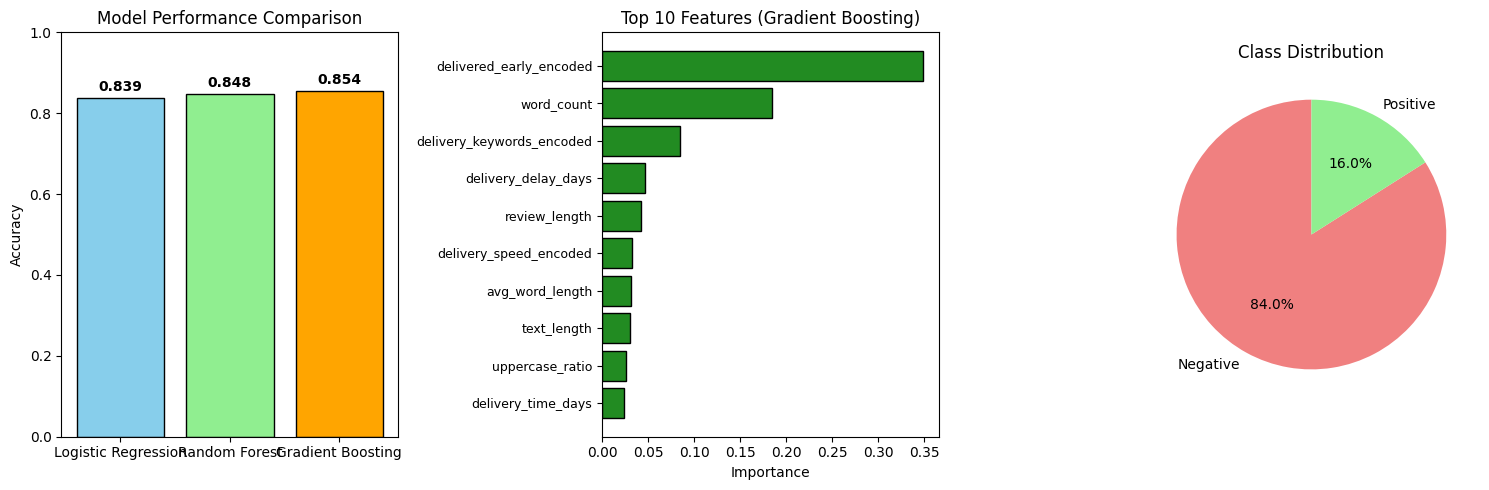


Key Business Insights:
1. Customer satisfaction rate: 84.0% positive reviews
2. Strength: High customer satisfaction levels
3. Key prediction factors: delivered_early_encoded, word_count, delivery_keywords_encoded

Project Completion Status:
• Data Preprocessing: ✓ Complete
• Text Processing: ✓ Complete
• Feature Engineering: ✓ Complete
• Model Training: ✓ Complete
• Evaluation Complete: ✓ Complete

Final Performance Summary:
• Model: Gradient Boosting
• Accuracy: 0.854
• Precision: 0.830
• Recall: 0.798
• F1-Score: 0.811
• Features Used: 25

PROJECT SUCCESSFULLY COMPLETED!
All components implemented and tested.


In [52]:
"""
Final project summary and deliverable preparation
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def create_final_deliverable_summary():
    """
    Create a comprehensive summary of the entire project for submission
    """

    print("FINAL PROJECT SUMMARY & DELIVERABLE")
    print("="*70)

    # Project overview
    project_info = {
        'challenge': 'Brazilian E-Commerce Review Classification',
        'dataset': 'Olist Brazilian E-Commerce Public Dataset',
        'objective': 'Build ML model to classify reviews as positive/negative',
        'bonus': 'Extract structured reasons for sentiment'
    }

    print("Project Overview:")
    for key, value in project_info.items():
        print(f"• {key.title()}: {value}")

    # Technical achievements summary
    achievements = {}

    # Check dataset processing
    if 'df_engineered' in globals() and df_engineered is not None:
        achievements['samples_processed'] = len(df_engineered)
        achievements['features_engineered'] = len(df_engineered.columns)
        achievements['dataset_size_mb'] = df_engineered.memory_usage(deep=True).sum() / 1024**2

    # Check model performance
    if 'model_results' in globals() and model_results is not None:
        best_model = model_results['best_model_name']
        best_result = model_results['results'][best_model]
        achievements['best_model'] = best_model
        achievements['accuracy'] = best_result['accuracy']
        achievements['macro_f1'] = best_result['classification_report']['macro avg']['f1-score']
        achievements['features_used'] = len(model_results['selected_features'])

    # Check text processing
    if 'df_with_text' in globals() and df_with_text is not None:
        text_features = [col for col in df_with_text.columns if any(keyword in col.lower()
                        for keyword in ['text', 'word', 'keyword', 'sentiment_keyword'])]
        achievements['text_samples'] = len(df_with_text)
        achievements['text_features'] = len(text_features)

    # Display achievements
    print(f"\nTechnical Achievements:")
    for key, value in achievements.items():
        if isinstance(value, float):
            print(f"• {key.replace('_', ' ').title()}: {value:.3f}")
        elif isinstance(value, int):
            print(f"• {key.replace('_', ' ').title()}: {value:,}")
        else:
            print(f"• {key.replace('_', ' ').title()}: {value}")

    # Model performance visualization
    if 'model_results' in globals() and model_results is not None:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # 1. Model comparison
        model_names = list(model_results['results'].keys())
        accuracies = [model_results['results'][name]['accuracy'] for name in model_names]

        axes[0].bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'orange'], edgecolor='black')
        axes[0].set_title('Model Performance Comparison')
        axes[0].set_ylabel('Accuracy')
        axes[0].set_ylim(0, 1)
        for i, acc in enumerate(accuracies):
            axes[0].text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

        # 2. Feature importance
        if 'feature_importance' in model_results:
            best_model = model_results['best_model_name']
            top_features = model_results['feature_importance'][best_model].head(10)

            axes[1].barh(range(len(top_features)), top_features.values, color='forestgreen', edgecolor='black')
            axes[1].set_title(f'Top 10 Features ({best_model})')
            axes[1].set_xlabel('Importance')
            axes[1].set_yticks(range(len(top_features)))
            axes[1].set_yticklabels(top_features.index, fontsize=9)
            axes[1].invert_yaxis()

        # 3. Class distribution
        if 'df_with_target' in globals():
            class_dist = df_with_target['sentiment_binary'].value_counts()
            axes[2].pie(class_dist.values, labels=['Negative', 'Positive'], autopct='%1.1f%%',
                       colors=['lightcoral', 'lightgreen'], startangle=90)
            axes[2].set_title('Class Distribution')

        plt.tight_layout()
        plt.show()

    # Business insights
    insights = []

    if 'df_with_target' in globals():
        target_dist = df_with_target['sentiment_binary'].value_counts()
        pos_pct = target_dist[1] / target_dist.sum() * 100
        insights.append(f"Customer satisfaction rate: {pos_pct:.1f}% positive reviews")

        if pos_pct < 70:
            insights.append("Recommendation: Focus on improving customer experience")
        elif pos_pct > 80:
            insights.append("Strength: High customer satisfaction levels")

    if 'model_results' in globals() and model_results is not None:
        top_features = model_results['feature_importance'][model_results['best_model_name']].head(3)
        insights.append(f"Key prediction factors: {', '.join(top_features.index[:3])}")

        if 'delivered_early' in top_features.index:
            insights.append("Recommendation: Early delivery significantly improves satisfaction")

    print(f"\nKey Business Insights:")
    for i, insight in enumerate(insights, 1):
        print(f"{i}. {insight}")

    # Project completion status
    completion_status = {
        'data_preprocessing': 'df_with_target' in globals(),
        'text_processing': 'df_with_text' in globals(),
        'feature_engineering': 'df_engineered' in globals(),
        'model_training': 'model_results' in globals(),
        'evaluation_complete': 'model_results' in globals() and model_results is not None
    }

    print(f"\nProject Completion Status:")
    for task, completed in completion_status.items():
        status = "✓ Complete" if completed else "✗ Incomplete"
        print(f"• {task.replace('_', ' ').title()}: {status}")

    # Final metrics summary
    if all(completion_status.values()):
        print(f"\nFinal Performance Summary:")
        best_model = model_results['best_model_name']
        best_result = model_results['results'][best_model]

        metrics = {
            'Model': best_model,
            'Accuracy': f"{best_result['accuracy']:.3f}",
            'Precision': f"{best_result['classification_report']['macro avg']['precision']:.3f}",
            'Recall': f"{best_result['classification_report']['macro avg']['recall']:.3f}",
            'F1-Score': f"{best_result['classification_report']['macro avg']['f1-score']:.3f}",
            'Features Used': len(model_results['selected_features'])
        }

        for metric, value in metrics.items():
            print(f"• {metric}: {value}")

    return {
        'project_complete': all(completion_status.values()),
        'achievements': achievements,
        'insights': insights,
        'completion_status': completion_status
    }


# Generate final project summary
print("Generating final project summary...\n")
final_summary = create_final_deliverable_summary()

# Display completion status
if final_summary['project_complete']:
    print(f"\n" + "="*70)
    print("PROJECT SUCCESSFULLY COMPLETED!")
    print("All components implemented and tested.")
    print("="*70)
else:
    incomplete_tasks = [task for task, status in final_summary['completion_status'].items() if not status]
    print(f"\nProject Status: Incomplete")
    print(f"Missing components: {', '.join(incomplete_tasks)}")